In [197]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import math
import numba as nb
# from testing_sample import *
import numpy as np
from scipy.interpolate import CubicSpline
# from calibration_fitt import *
from numba import njit


In [198]:
@nb.njit
def counts_of_peak_in_index(counts,peak_index):
    counts_in_peak = []
    for i in range(len(counts)):
        if i in peak_index:
            counts_in_peak.append(counts[i])
    return counts_in_peak  

In [199]:
def gauss(x, A, x0, sigma, y0):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0


def pseudo_voigt(x, A, x0, fwhm, eta, y0):
    """
    eta ∈ [0,1] – udział Lorentza
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gauss_part = np.exp(-(x - x0)**2 / (2 * sigma**2))
    lorentz_part = 1 / (1 + ((x - x0) / (fwhm / 2))**2)
    return A * (eta * lorentz_part + (1 - eta) * gauss_part) + y0

In [200]:
class Data_file:
    def __init__(self,index,filename="data_storage.json"):
        self.index = index
        ''' reading data function but without hkl and everything of hkl file'''
        with open(filename, "r", encoding="utf-8") as file:
            data = json.load(file)
            sample = data[self.index]
            self.name = sample["name"]
            self.path = sample["data"]["path"] 
            self.kalpha1 = np.asarray(sample["data"]["kalpha1"][0])
            self.kalpha2 = np.asarray(sample["data"]["kalpha2"][0])
            self.theta_start = np.asarray(sample["data"]["theta_start"][0])
            self.theta_stop = np.asarray(sample["data"]["theta_stop"][0])
            self.uvw_xy = np.asarray(sample["data"]["uvw_xy"] )
            self.start_step_end = np.asarray(sample["data"]["start_step_end"] )
            self.counts = np.asarray(json.loads(sample["data"]["counts"]), dtype=float )
            self.counts_bac = np.asarray(json.loads(sample["data"]["counts_bac"] ),dtype=float)
            self.xy_and_u_fitted = sample["data"]["x_y_fitted"]
        nr_of_step = len(self.counts)
        self.x = np.linspace(self.theta_start, self.theta_stop, nr_of_step)
        if nr_of_step > 1:
            self.step = (self.theta_stop - self.theta_start) / (nr_of_step - 1)
        else:
            self.step = 0.0
        
    def del_low_intense_peaks(self):
        index = []
        for i in range(len(self.f2)):
            if self.f2[i]<100:
                index.append(i)
        return index
    
    def del_duplicates(self,two_theta,fwhm,eps=0.001):
        index = self.del_low_intense_peaks()
        temp,temp0,temp_fwhm,temp_fwhm0 = [],[],[],[]
        for i in range(len(two_theta)):
            if i in index:
                continue
            else:
                temp0.append(two_theta[i])
                temp_fwhm0.append(fwhm[i])
        for i in range(len(temp0)-1):
            if abs(temp0[i]-temp0[i+1])<eps:
                continue
            else:
                temp.append(temp0[i])
                temp_fwhm.append(temp_fwhm0[i])
        if temp0[-1] not in temp:
            temp.append(temp0[-1])
            temp_fwhm.append(temp_fwhm0[-1]) 
        return np.asarray(temp, dtype=np.float64),np.asarray(temp_fwhm, dtype=np.float64)

    def read_data_of_hkl(self,filename="data_storage.json"):
        '''function reading data hkl and everything of hkl file and reducing doubled two theta peaks '''
        with open(filename, "r", encoding="utf-8") as file:
            data = json.load(file)
            sample = data[self.index]
            self.hkl_plus = sample["data"]["hkl"][0]
        self.h = self.hkl_plus['h']
        self.k = self.hkl_plus['k']
        self.l = self.hkl_plus['l']
        self.mult = self.hkl_plus['mult']
        self.sinT_lamb = self.hkl_plus['sinT_lamb']
        self.two_theta = self.hkl_plus['tt']
        self.fwhm = self.hkl_plus['fwhm']
        self.f2 = self.hkl_plus['f2']
        self.sf2 = self.hkl_plus['sf2']
        self.two_theta,self.fwhm = self.del_duplicates(self.two_theta,self.fwhm,0.001)

    # def without_ap(self,without_ap_counts):
    #     self.without_aparature_counts =  np.asarray(without_ap_counts, dtype=float )
        
    def find_counts_of(self,peaks):
        counts_of_peak_in_index(self.counts,peaks)
        self.two_theta_in_counts = np.asarray(peaks,dtype=int )

    def del_bac_counts(self,only_counts):
        self.without_bac_counts = np.asarray(only_counts, dtype=float )
    
    def set_calibration(self,calibration_ap_fit):
        self.calibration_ap_fit = calibration_ap_fit

    def plot_counts_with_peaks_fwhm_and_fit(
        self,
        n_panels=4,
        model="gauss",     # "gauss" lub "pvoigt"
        fit_window=3.0     # ile × FWHM brać do dopasowania
    ):
        if not hasattr(self, "two_theta"):
            raise ValueError("Najpierw wywołaj read_data_of_hkl()")

        fig, axes = plt.subplots(
            n_panels, 1, figsize=(10, 2.8 * n_panels), sharex=False
        )

        if n_panels == 1:
            axes = [axes]

        theta_min = self.x.min()
        theta_max = self.x.max()
        panel_width = (theta_max - theta_min) / n_panels

        for i, ax in enumerate(axes):
            left = theta_min + i * panel_width
            right = left + panel_width

            mask = (self.x >= left) & (self.x < right)
            if not np.any(mask):
                ax.set_visible(False)
                continue

            x_seg = self.x[mask]
            y_seg = self.counts[mask]

            ax.plot(x_seg, y_seg, color="black", lw=1)

            # autoskalowanie Y
            ymin, ymax = y_seg.min(), y_seg.max()
            dy = ymax - ymin if ymax > ymin else ymax
            ax.set_ylim(ymin - 0.05 * dy, ymax + 0.15 * dy)

            for tt, fwhm in zip(self.two_theta, self.fwhm):
                if not (left <= tt < right):
                    continue

                # zaznaczenie piku
                ax.axvline(tt, color="red", linestyle="--", alpha=0.6)

                half = fwhm /2
                y_peak = np.interp(tt, self.x, self.counts)

                ax.hlines(
                    y_peak / 2,
                    tt - half,
                    tt + half,
                    color="blue",
                    linewidth=2
                )

                # -------- FIT --------
                window = fit_window * fwhm
                fit_mask = (self.x > tt - window) & (self.x < tt + window)

                if np.sum(fit_mask) < 5:
                    continue

                x_fit = self.x[fit_mask]
                y_fit = self.counts[fit_mask]

                try:
                    if model == "gauss":
                        p0 = [y_peak, tt, fwhm / 2.355, np.min(y_fit)]
                        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0)
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            gauss(x_dense, *popt),
                            color="green",
                            lw=2
                        )

                    elif model == "pvoigt":
                        p0 = [y_peak, tt, fwhm, 0.5, np.min(y_fit)]
                        bounds = (
                            [0, tt - fwhm, 0, 0, 0],
                            [np.inf, tt + fwhm, np.inf, 1, np.inf]
                        )
                        popt, _ = curve_fit(
                            pseudo_voigt,
                            x_fit,
                            y_fit,
                            p0=p0,
                            bounds=bounds
                        )
                        x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)
                        ax.plot(
                            x_dense,
                            pseudo_voigt(x_dense, *popt),
                            color="darkorange",
                            lw=2
                        )

                except RuntimeError:
                    pass  # brak zbieżności fitu – ignorujemy

            ax.set_xlim(left, right)
            ax.set_ylabel("Counts")
            ax.grid(True, alpha=0.3)

        axes[-1].set_xlabel(r"$2\theta$")
        fig.suptitle(
            f"XRD: piki + FWHM + dopasowanie ({model}) – {self.name}",
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

    def scherrer_size(self, wavelength=1.5406, K=1):
        sizes = []
        for tt, fwhm in zip(self.two_theta, self.fwhm):
            theta = np.deg2rad(tt / 2)
            beta = np.deg2rad(fwhm)  # w radianach

            if beta > 0:
                D = K * wavelength / (beta * np.cos(theta))
                sizes.append((tt, D))

        return np.array(sizes)




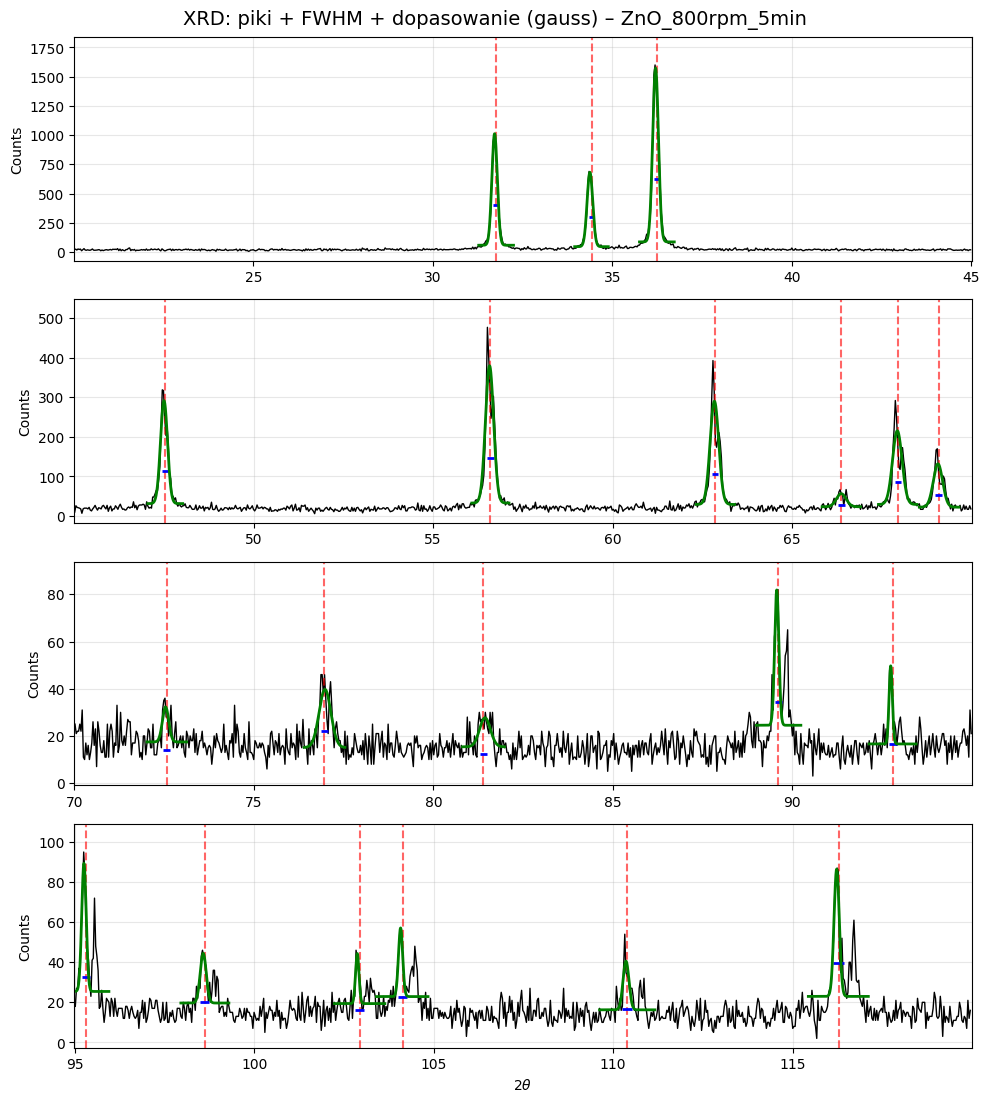

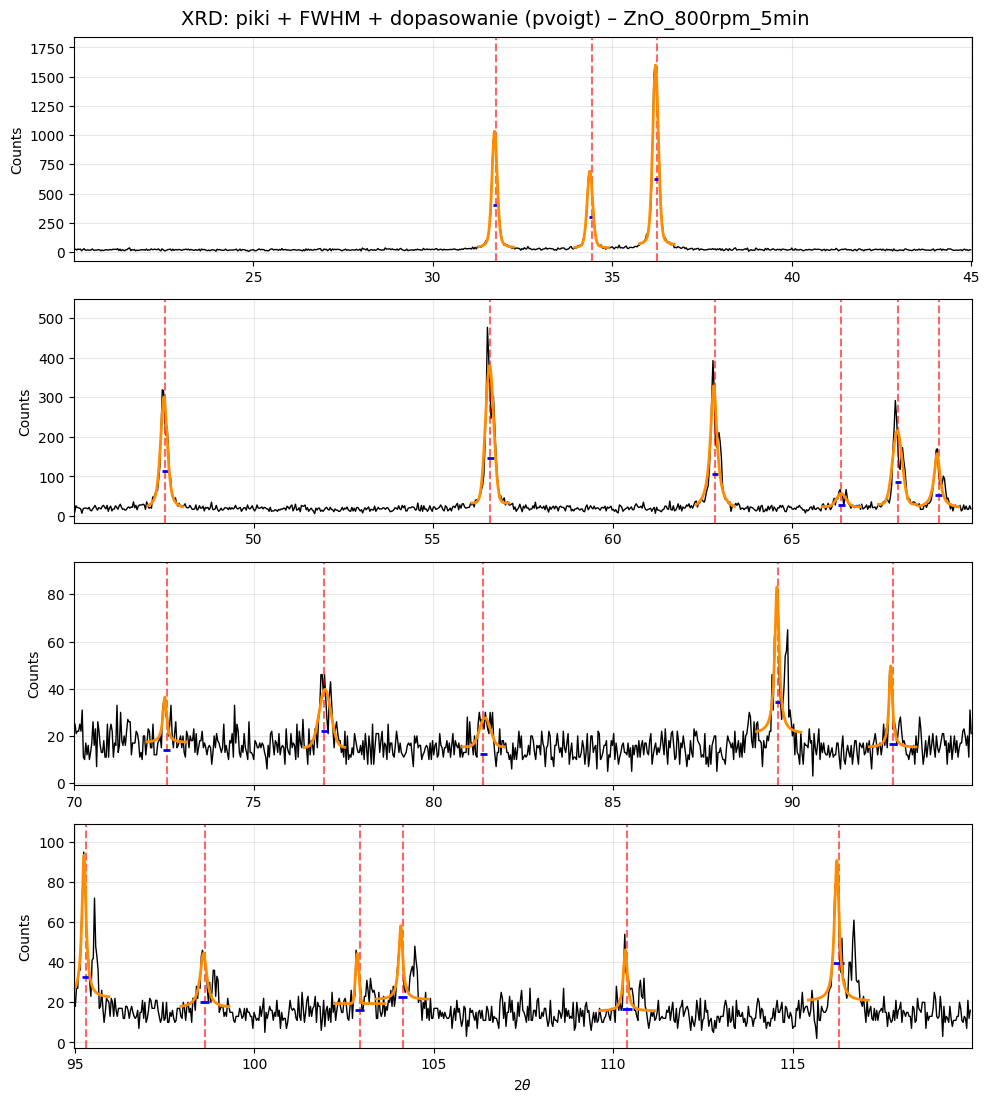

In [205]:
#create class element - aparature
ap = Data_file(-1)
#create class element - sample
f = Data_file(70)
f.read_data_of_hkl()
# Gauss
f.plot_counts_with_peaks_fwhm_and_fit(model="gauss")

# pseudo-Voigt (zalecane do XRD)
f.plot_counts_with_peaks_fwhm_and_fit(model="pvoigt")




In [206]:
print(len(f.two_theta))
print(len(f.fwhm))

20
20


[0.16563 0.16648 0.16712 0.17212 0.17759 0.18228 0.18529 0.18672 0.1878
 0.19131 0.19624 0.20181 0.21412 0.21968 0.22443 0.23124 0.24117 0.24417
 0.26173 0.28186]
[ 31.769   34.422   36.2541  47.5401  56.5964  62.8581  66.3773  67.9491
  69.0879  72.5672  76.9613  81.3867  89.6144  92.7945  95.3092  98.6199
 102.9357 104.1356 110.3894 116.2786]


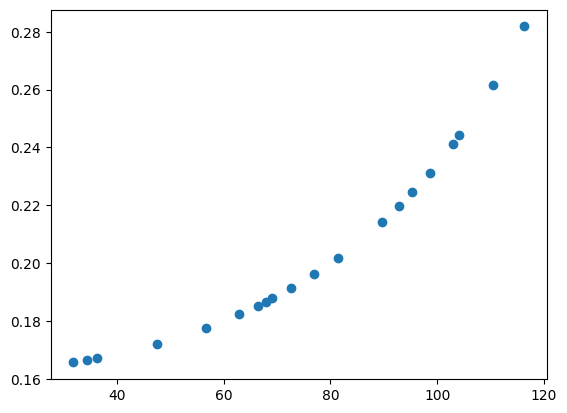

In [207]:
print(f.fwhm)
print(f.two_theta)
plt.scatter(f.two_theta,f.fwhm)

In [208]:
PI = 3.141592654


In [209]:
print(f.two_theta[2])
print(f.two_theta[4])
print(f.two_theta[7])
print(f.two_theta[9])

36.2541
56.5964
67.9491
72.5672


0.1998667912167528
-14.05782287038642
7.708123949061865


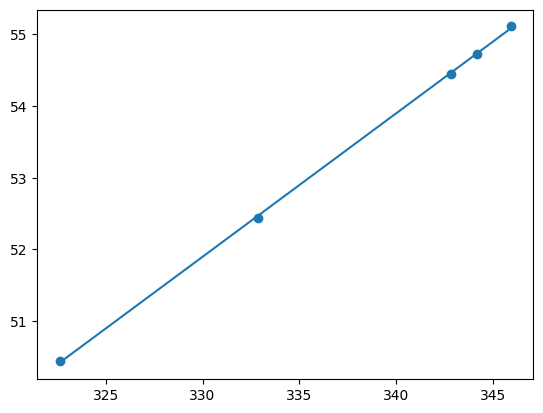

In [210]:
xline,yline = [],[]
for i in range(len(f.two_theta)-15):
    xline.append(1/(f.fwhm[i]*PI/180))
    yline.append(180*math.cos(f.two_theta[i]/2*PI/180)/PI)
# xline = [1/(f.fwhm[2]*PI/180),1/(f.fwhm[4]*PI/180),1/(f.fwhm[7]*PI/180),1/(f.fwhm[9]*PI/180)]
# yline = [180*math.cos(f.two_theta[2]/2*PI/180)/PI,180*math.cos(f.two_theta[4]/2*PI/180)/PI,180*math.cos(f.two_theta[7]/2*PI/180)/PI,180*math.cos(f.two_theta[9]/2*PI/180)/PI]
plt.scatter(xline,yline)
aschr, bschr= np.polyfit(xline, yline, 1)
y_line = []
for i in range(len(xline)):
    y_line.append(aschr*xline[i]+bschr)
plt.plot(xline,y_line)
print(aschr)
print(bschr)
size_schr = 1*f.kalpha1/aschr
print(size_schr)

0.7896817762867382


-5.877305110549887
549.7566706274729


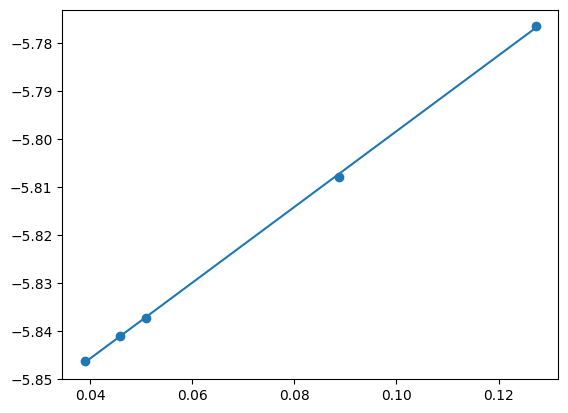

In [211]:
# yline = [math.log(f.fwhm[2]*PI/180),math.log(f.fwhm[4]*PI/180),math.log(f.fwhm[7]*PI/180),math.log(f.fwhm[9]*PI/180)]
# xline = [math.log(1/(math.cos(f.two_theta[2]/2*PI/180))),math.log(1/(math.cos(f.two_theta[4]/2*PI/180))),math.log(1/(math.cos(f.two_theta[7]/2*PI/180))),math.log(1/(math.cos(f.two_theta[9]/2*PI/180)))]
xline,yline = [],[]
for i in range(len(f.two_theta)-15):
    xline.append(math.log(1/(math.cos(f.two_theta[i]/2*PI/180))))
    yline.append(math.log(f.fwhm[i]*PI/180))
plt.scatter(xline,yline)

aschr, bschr= np.polyfit(xline, yline, 1)
y_line = []
for i in range(len(xline)):
    y_line.append(aschr*xline[i]+bschr)
plt.plot(xline,y_line)
print(aschr)
print(bschr)
size_schr = 1*f.kalpha1/math.e**bschr
print(size_schr)

In [212]:
@njit
def gaussian(x, A, x0, sigma):
    return A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)

In [213]:
@njit
def rr2(x_fit,y_fit,A_guess, x0_guess, sigma_guess):
    fit_y = gaussian(x_fit, A_guess, x0_guess, sigma_guess)
    ss_res = np.sum((y_fit - fit_y) ** 2)
    ss_tot = np.sum((y_fit - np.mean(y_fit)) ** 2)
    return  1 - ss_res / ss_tot

In [214]:
def peak_detect_gauss_quality(counts, x, r2_min=0.9, fit_range=10, height=None, distance=None, prominence=None):
    """
    Peak detection + Gaussian fitting with R² quality filter.
    Returns:
        good_peaks : np.ndarray (indices)
        x_peaks    : np.ndarray (x values of peaks)
        y_peaks    : np.ndarray (y values of peaks)
        gauss_fit  : list of fitted parameters [A, mu, sigma]
        r2_list    : list of R² values
    """
    peaks, _ = find_peaks(
        counts,
        height=height,
        distance=distance,
        prominence=prominence
    )
    if len(peaks) == 0:
        return np.array([]), np.array([]), np.array([]), [], []

    good_peaks, x_peaks, y_peaks, gauss_fit, r2_list = [],[],[],[],[]
    for pk in peaks:
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A0 = counts[pk]
        mu0 = x[pk]
        sigma0 = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1.0
        try:
            popt, _ = curve_fit(
                gaussian,
                x_fit,
                y_fit,
                p0=[A0, mu0, sigma0],
                bounds=(
                    [0.0, mu0 - fit_range, 1e-3],
                    [np.inf, mu0 + fit_range, np.inf]
                )
            )
            r2 = rr2(x_fit, y_fit, *popt)
            if r2 >= r2_min:
                good_peaks.append(pk)
                x_peaks.append(x[pk])
                y_peaks.append(counts[pk])
                gauss_fit.append(popt)
                r2_list.append(r2)
        except RuntimeError:
            continue
    return np.array(y_peaks),gauss_fit,r2_list

In [215]:
def finding_fwhm_ap(peaks, gauss_fit):
    """
    Calculate FWHM and peak positions from Gaussian fit parameters.
    gauss_fit: array-like of shape (N, 3)
        Each row: [A, mu, sigma]
    """
    peaks = np.asarray(peaks)
    peaks_max = np.max(peaks)
    peaks_weight = np.zeros(len(peaks))
    peaks_weight = peaks/peaks_max

    gauss_fit = np.asarray(gauss_fit)
    sigma = np.abs(gauss_fit[:, 2])
    mu = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    t_fwhm = mu
    return fwhm, t_fwhm, peaks_weight

In [216]:
def fit_poly_lower(x, y, weight, x_min=60, q=0.2, deg=1, log_weight=False ):
    x = np.asarray(x)
    y = np.asarray(y)
    weight = np.asarray(weight)
    mask = x >= x_min
    x0 = x[mask]
    y0 = y[mask]
    w0 = weight[mask]

    if len(x0) < deg + 1:
        return (
            np.full_like(x, np.nan, dtype=float),
            None,
            np.full_like(x, np.nan, dtype=float)
        )
    coeffs = np.polyfit(x0, y0, deg, w=w0)
    poly = np.poly1d(coeffs)
    y_fit = poly(x)
    y_fit[x < x_min] = np.nan

    w = weight.astype(float)
    if log_weight:
        w = np.log1p(w)
    w_min, w_max = np.nanmin(w), np.nanmax(w)
    if w_max > w_min:
        w_norm = (w - w_min) / (w_max - w_min)
    else:
        w_norm = np.zeros_like(w)
    w_norm[x < x_min] = np.nan
    return y_fit, poly, w_norm

In [217]:
def set_aparature_fit(counts,x,r2_min = 0.6,plotting = False,height=None,dist=None,prom=None):
    ap_good_peaks_counts,ap_gauss_fit,_ = peak_detect_gauss_quality(counts,x,r2_min,height=height, distance=dist, prominence=prom)
    ap_fwhm,ap_t_fwhm,ap_peaks_weight = finding_fwhm_ap(ap_good_peaks_counts,ap_gauss_fit)
    y_fit,poly, colorscale = fit_poly_lower(ap_t_fwhm, ap_fwhm,ap_peaks_weight, x_min=0, q=0.2, deg=2)

    if plotting == True:
        plt.figure(figsize=(8, 5))
        plt.scatter(ap_t_fwhm, ap_fwhm, s=30, alpha=0.7, label="dane", c=colorscale,cmap="viridis")
        plt.plot(ap_t_fwhm, y_fit, linewidth=2, label=f"polyfit deg={poly.order}")
        plt.colorbar(label="Znaczenie punktu")
        plt.legend()
        plt.grid(True)
        plt.show()
    return y_fit,ap_t_fwhm

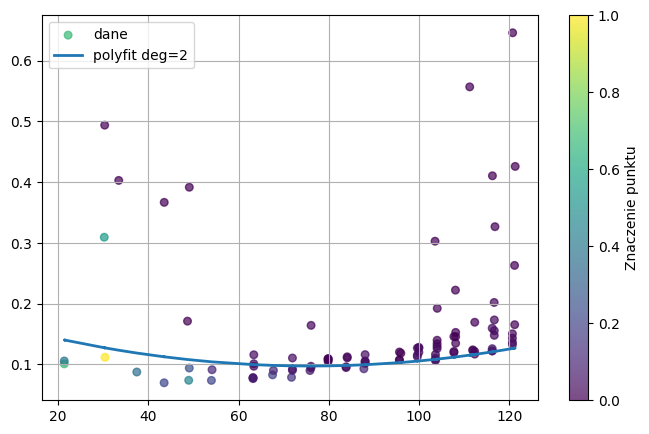

In [218]:
# y_ap_fit0,ap_x_fit0 = set_aparature_fit(ap.counts,ap.x,plotting=True)
y_ap_fit,ap_x_fit = set_aparature_fit(ap.counts,ap.x,plotting=True,height=20,prom=1)


In [219]:
# idx = np.argsort(ap_x_fit0)
# x = ap_x_fit0[idx]
# y = y_ap_fit0[idx]
# # spline
# cs = CubicSpline(x, y)
# # gęsta siatka X
# x_dense = np.linspace(x.min(), x.max(), 1000)
# y_dense = cs(x_dense)

# plt.figure(figsize=(8,5))
# plt.plot(x, y, 'o', label='oryginalne punkty',color = "red")
# plt.plot(x_dense, y_dense, '-', label='interpolacja spline')
# plt.scatter(x_dense, y_dense, label='interpolacja spline')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.grid(True)
# plt.show()
# y_two_theta_fit = cs(f.two_theta)


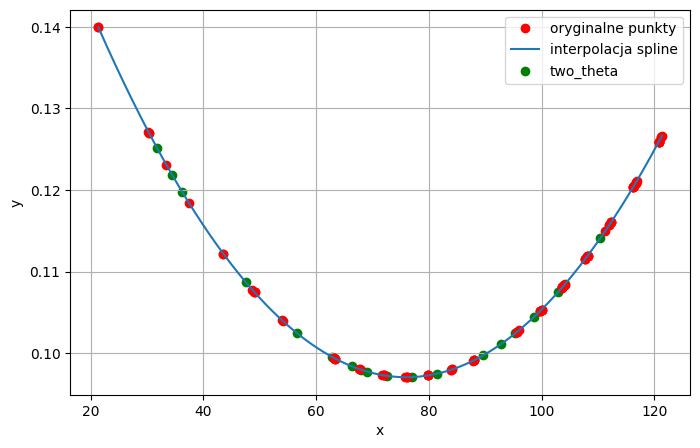

In [220]:

idx1 = np.argsort(ap_x_fit)
x1 = ap_x_fit[idx1]
y1 = y_ap_fit[idx1]


from scipy.interpolate import CubicSpline

# spline
cs1 = CubicSpline(x1, y1)

# gęsta siatka X
x_dense1 = np.linspace(x1.min(), x1.max(), 1000)
y_dense1 = cs1(x_dense1)

import matplotlib.pyplot as plt

y_two_theta_fit1 = cs1(f.two_theta)

plt.figure(figsize=(8,5))
plt.plot(x1, y1, 'o', label='oryginalne punkty',color = "red")
plt.plot(x_dense1, y_dense1, '-', label='interpolacja spline')
plt.scatter(f.two_theta, y_two_theta_fit1, label='two_theta',color = "green")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [221]:
@njit
def find_index_of_two_theta(two_theta,theta_start,step):
    '''function finding peak index in range of x where peak from two theta extsts'''
    peaks = np.zeros(len(two_theta))
    for i in range(len(two_theta)):
        peaks[i] = (two_theta[i]-theta_start)/step
    for i in range(len(peaks)):
        if peaks[i]-int(peaks[i])>0.5:
            peaks[i] = int(peaks[i]+1)
        else:
            peaks[i] = int(peaks[i]) 
    return peaks

In [222]:
f.find_counts_of(find_index_of_two_theta(f.two_theta,f.theta_start,f.step))
print(f.two_theta_in_counts)
print(f.two_theta)

[ 352  431  486  824 1094 1282 1387 1434 1468 1572 1704 1836 2082 2178
 2253 2352 2481 2517 2704 2880]
[ 31.769   34.422   36.2541  47.5401  56.5964  62.8581  66.3773  67.9491
  69.0879  72.5672  76.9613  81.3867  89.6144  92.7945  95.3092  98.6199
 102.9357 104.1356 110.3894 116.2786]


In [223]:
def plot_with_theta_sample(counts,name,two_theta,x):
    plt.plot(x, counts, label="Dane próbki", color="blue")
    for i in range(len(two_theta)):
        plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
    plt.xlabel(r"2$\theta$")
    plt.ylabel("Liczba zliczeń")
    plt.title(f"Widmo próbki \"{name}\" z zaznaczeniem istniejących pików")
    plt.legend()
    plt.show()

Plot all counts


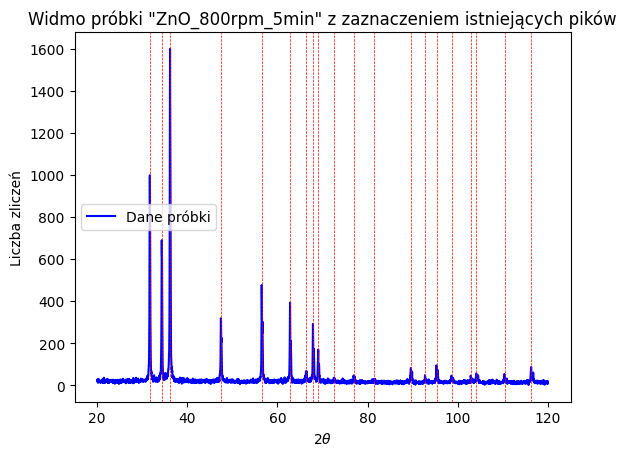

Plot without background counts
Plot without background and aparature counts


In [224]:
print("Plot all counts")
plot_with_theta_sample(f.counts,f.name,f.two_theta,f.x)
print("Plot without background counts")
# plot_with_theta_sample(f.without_bac_counts,f.name,f.two_theta,f.x)
print("Plot without background and aparature counts")
# plot_with_theta_sample(f.without_aparature_counts,f.name,f.two_theta,f.x)

In [225]:
counts_in_peak  = counts_of_peak_in_index(f.counts,f.two_theta_in_counts)
print(min(counts_in_peak))
print(max(counts_in_peak ))
print((f.two_theta_in_counts))

23.0
1210.0
[ 352  431  486  824 1094 1282 1387 1434 1468 1572 1704 1836 2082 2178
 2253 2352 2481 2517 2704 2880]


In [226]:
#parameters to calculate stain and size of cristalite
print(f.xy_and_u_fitted)
print(f.uvw_xy)

[9e-05, 2.7581000000000006e-05, 0.085, 0.013542271000000002]
False


In [227]:
def plot_gauss_ap(peaks,count,x,segment_width = 15):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        plt.xlim(seg_start, seg_end)
        plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()


In [228]:
def checking_what_found(peaks,counts,correct_peaks,two_theta,x):
    plt.plot(two_theta,counts[two_theta])


spróbować dopasować aparaturę ale tak żeby odejmować od pików wkład piku a nie po prostu 
sprawdzić możliwości find_peaks czy da się wprowadzić inny model do dopasowania i ewentualnie go dodać do naszych danych
sprawdzić jak można wprowadzić wkład lagranżowski do danych 
przygotować przezentacje - pare slajdów o otrzymanych danych, wykresach co moznaby ewentualnie dodać do pracy 


In [229]:
def plot_gauss(correct_peaks,peaks,count,x,two_theta,segment_width = 15):
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        local_corr_peaks = [pk for pk in correct_peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_corr_peaks], count[local_corr_peaks], color='red', zorder=10, label='Piki poprawne')
        for i in range(len(two_theta)):
            plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
        plt.xlim(seg_start, seg_end)
        plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

In [230]:
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect_ap(ap.counts,ap.x,0, 10, 0.001,ap.theta_start,ap.step,4,True,True,fit_range=500)


In [231]:
def which_was_found(correct_peaks, x, counts, two_theta, two_theta_in_counts):
    plt.plot(x, counts, color="orange",linestyle='--', linewidth=0.5)
    plt.scatter(x[correct_peaks], counts[correct_peaks], color="green",label="piki znalezione przez algorytm")
    plt.scatter(two_theta, counts[two_theta_in_counts],color="blue", label="piki wzorcowe")
    plt.xlabel("2θ [stopnie]")
    plt.ylabel("Ilość zliczeń")
    plt.title("Porównanie pików znalezionych i wzorcowych")
    plt.legend()
    plt.show()
    eps = [0, 1, 2, 3, -1, -2, -3]
    find_peaks_theta = []
    not_find_peaks = []
    correct_peaks_set = set(correct_peaks)
    for idx in two_theta_in_counts:
        matched = any((idx + e) in correct_peaks_set for e in eps)
        if matched:
            find_peaks_theta.append(idx)
        else:
            not_find_peaks.append(idx)
    plt.figure()
    # plt.plot(x, counts, color="orange")
    # plt.title("Zebranie pików odnalezionych i nie odnalezionych przez algorytm")
    plt.title("Znalezione i nieznalezione piki (dokładność ±3 punkty)")
    plt.scatter(
        x[find_peaks_theta],
        counts[find_peaks_theta],
        label=fr"znalezione piki: {len(find_peaks_theta)}/{len(two_theta)}",
        color = "blue"
    )
    plt.legend()
    plt.xlabel("2θ [stopnie]")
    plt.ylabel("Ilość zliczeń")
    # plt.show()
    # plt.title("nie znalezione")
    # plt.plot(x, counts, color="orange")
    plt.scatter(
        x[not_find_peaks],
        counts[not_find_peaks],
        label=fr"nieznalezione piki: {len(not_find_peaks)}/{len(two_theta)}",
        color = "red"
    )
    plt.axhline(np.max(counts[not_find_peaks]),label = fr"maksymalna nieznaleziona liczba zliczeń: {np.max(counts[not_find_peaks])} ",color="red",linestyle='--', linewidth=0.6)
    plt.legend()
    plt.show()
    return find_peaks_theta

In [232]:
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,5, 55, 0.001,f.two_theta,f.theta_start,f.step,4,False,True)
# fwhm,t_fwhm,diff = finding_fwhm_plot(f.without_aparature_counts,index_corrected,f.x,gauss_fit,f.theta_start,f.step,plotting = True)
# finding_fwhm(f.counts,correct_peaks,index_corrected,f.x,gauss_fit)

# which_was_found(correct_peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)
# which_was_found(peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)



In [233]:
print(f.fwhm)
print(f.two_theta)
# print(f.two_theta_in_counts)
print(len(f.fwhm))
print(len(f.two_theta))

[0.16563 0.16648 0.16712 0.17212 0.17759 0.18228 0.18529 0.18672 0.1878
 0.19131 0.19624 0.20181 0.21412 0.21968 0.22443 0.23124 0.24117 0.24417
 0.26173 0.28186]
[ 31.769   34.422   36.2541  47.5401  56.5964  62.8581  66.3773  67.9491
  69.0879  72.5672  76.9613  81.3867  89.6144  92.7945  95.3092  98.6199
 102.9357 104.1356 110.3894 116.2786]
20
20


In [234]:
def peak_detect_gauss_quality(counts, x, r2_min=0.9, fit_range=10, height=None, distance=None, prominence=None):
    """
    Peak detection + Gaussian fitting with R² quality filter.
    Returns:
        good_peaks : np.ndarray (indices)
        x_peaks    : np.ndarray (x values of peaks)
        y_peaks    : np.ndarray (y values of peaks)
        gauss_fit  : list of fitted parameters [A, mu, sigma]
        r2_list    : list of R² values
    """
    peaks, _ = find_peaks(
        counts,
        height=height,
        distance=distance,
        prominence=prominence
    )
    if len(peaks) == 0:
        return np.array([]), np.array([]), np.array([]), [], []

    good_peaks, x_peaks, y_peaks, gauss_fit, r2_list = [],[],[],[],[]
    for pk in peaks:
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A0 = counts[pk]
        mu0 = x[pk]
        sigma0 = (x_fit[-1] - x_fit[0]) / 6 if len(x_fit) > 1 else 1.0
        try:
            popt, _ = curve_fit(
                gaussian,
                x_fit,
                y_fit,
                p0=[A0, mu0, sigma0],
                bounds=(
                    [0.0, mu0 - fit_range, 1e-3],
                    [np.inf, mu0 + fit_range, np.inf]
                )
            )
            r2 = rr2(x_fit, y_fit, *popt)
            if r2 >= r2_min:
                good_peaks.append(pk)
                x_peaks.append(x[pk])
                y_peaks.append(counts[pk])
                gauss_fit.append(popt)
                r2_list.append(r2)
        except RuntimeError:
            continue
    return np.array(y_peaks),np.array(x_peaks),np.array(good_peaks),gauss_fit,r2_list

In [235]:
y_peaks_f,x_peaks_f,index_peaks_f,gauss_fit,_ = peak_detect_gauss_quality(f.counts,f.x,r2_min=0.6)


In [236]:
def plot_counts_with_peaks_fwhm_and_fit_from_peaks(
    counts,
    x,
    peak_indices,
    gauss_fit,
    model="gauss",      # "gauss" albo "pvoigt"
    n_panels=4,
    fit_window=3.0
):
    """
    Rysuje:
    - widmo XRD
    - piki znalezione algorytmem
    - FWHM (z fitu Gaussa)
    - dopasowanie Gauss / pseudo-Voigt

    Jednostki:
    x        -> 2θ [stopnie]
    sigma    -> stopnie (2θ)
    fwhm     -> stopnie (2θ)
    """

    fig, axes = plt.subplots(
        n_panels, 1, figsize=(10, 2.8 * n_panels), sharex=False
    )

    if n_panels == 1:
        axes = [axes]

    theta_min = x.min()
    theta_max = x.max()
    panel_width = (theta_max - theta_min) / n_panels

    for i, ax in enumerate(axes):
        left = theta_min + i * panel_width
        right = left + panel_width

        mask = (x >= left) & (x < right)
        if not np.any(mask):
            ax.set_visible(False)
            continue

        x_seg = x[mask]
        y_seg = counts[mask]

        ax.plot(x_seg, y_seg, color="black", lw=1)

        ymin, ymax = y_seg.min(), y_seg.max()
        dy = ymax - ymin if ymax > ymin else ymax
        ax.set_ylim(ymin - 0.05 * dy, ymax + 0.15 * dy)

        # --- piki ---
        for pk, popt in zip(peak_indices, gauss_fit):
            mu = popt[1]
            sigma = abs(popt[2])
            fwhm = 2 * sigma * np.sqrt(2 * np.log(2))

            if not (left <= mu < right):
                continue

            # pozycja piku
            ax.axvline(mu, color="red", linestyle="--", alpha=0.6)

            y_peak = counts[pk]

            # FWHM
            ax.hlines(
                y_peak / 2,
                mu - fwhm / 2,
                mu + fwhm / 2,
                color="blue",
                linewidth=2
            )

            # -------- FIT --------
            window = fit_window * fwhm
            fit_mask = (x > mu - window) & (x < mu + window)
            if np.sum(fit_mask) < 5:
                continue

            x_fit = x[fit_mask]
            y_fit = counts[fit_mask]

            x_dense = np.linspace(x_fit.min(), x_fit.max(), 400)

            if model == "gauss":
                ax.plot(
                    x_dense,
                    gaussian(x_dense, *popt),
                    color="green",
                    lw=2
                )

            elif model == "pvoigt":
                A = popt[0]
                y0 = np.min(y_fit)
                p0 = [A, mu, fwhm, 0.5, y0]
                bounds = (
                    [0, mu - fwhm, 0, 0, 0],
                    [np.inf, mu + fwhm, np.inf, 1, np.inf]
                )
                try:
                    popt_v, _ = curve_fit(
                        pseudo_voigt,
                        x_fit,
                        y_fit,
                        p0=p0,
                        bounds=bounds
                    )
                    ax.plot(
                        x_dense,
                        pseudo_voigt(x_dense, *popt_v),
                        color="darkorange",
                        lw=2
                    )
                except RuntimeError:
                    pass

        ax.set_xlim(left, right)
        ax.set_ylabel("Counts")
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel(r"$2\theta$ [°]")
    fig.suptitle(
        f"XRD: piki + FWHM + dopasowanie ({model})",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()



Tworzę 7 wykresów (co 15° 2θ)...


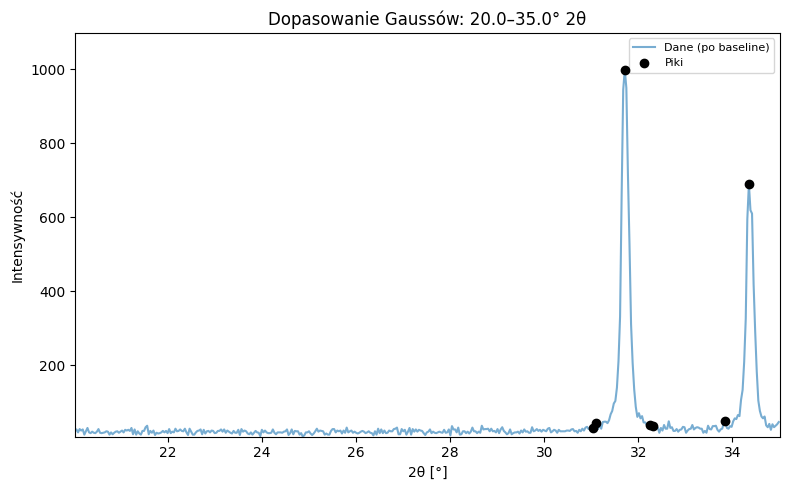

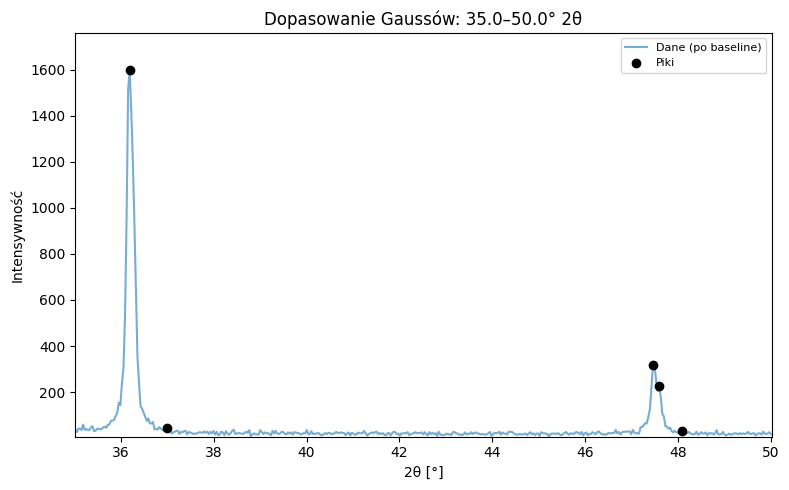

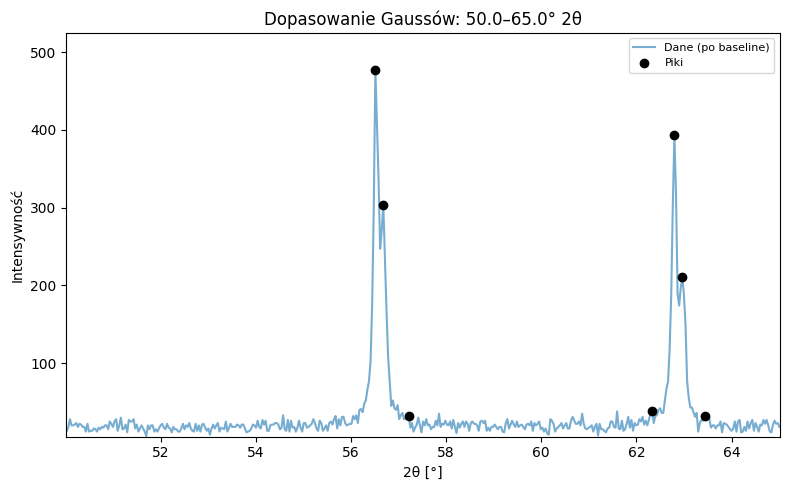

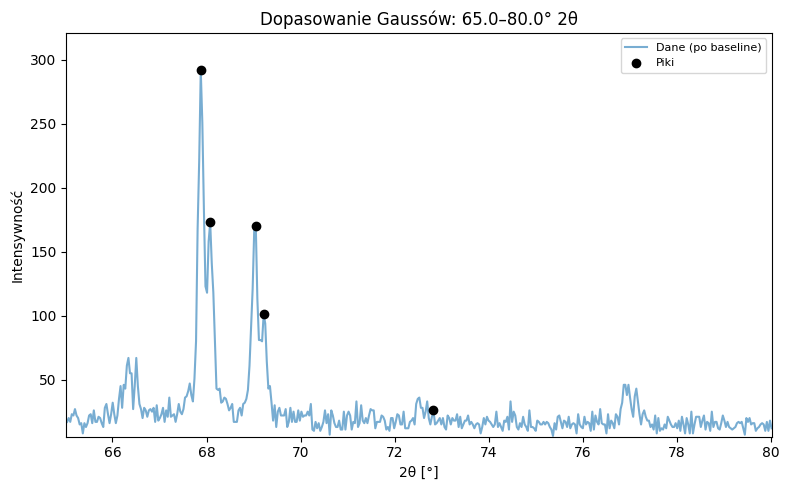

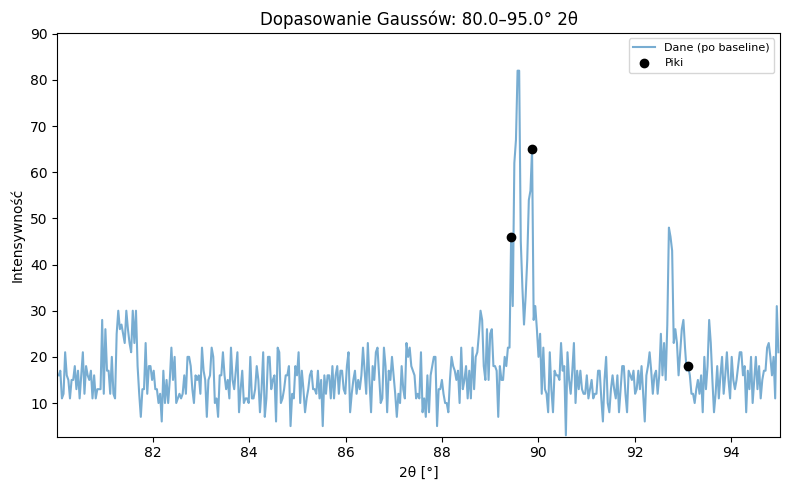

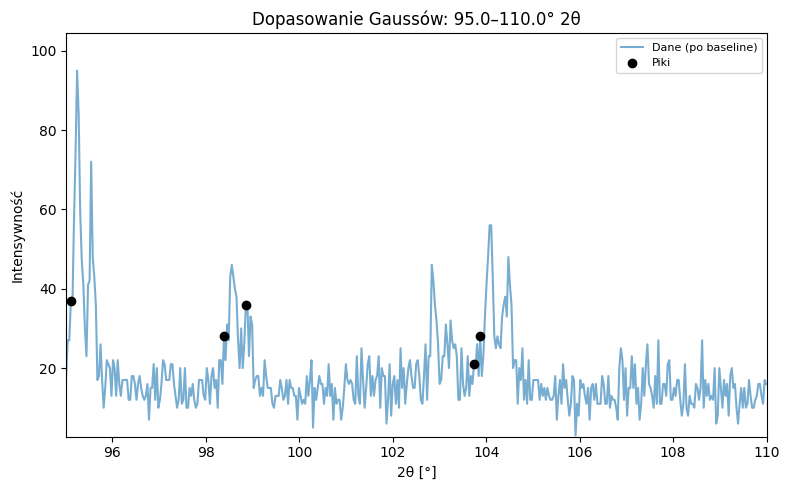

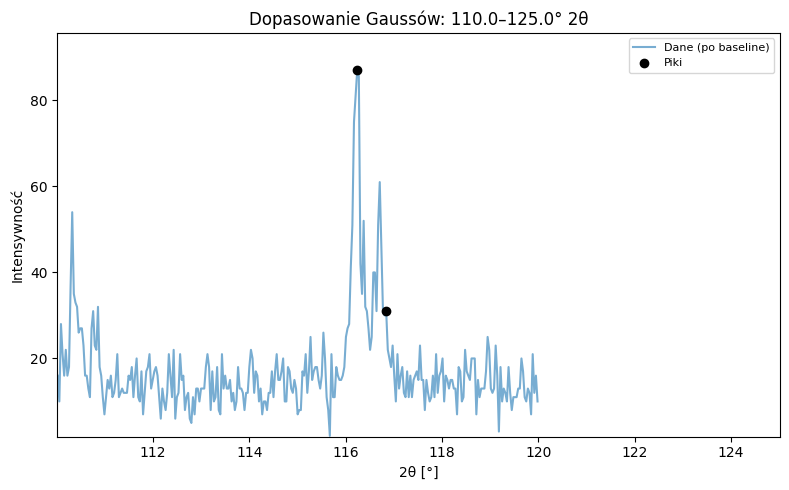

In [237]:
plot_gauss_ap(index_peaks_f,f.counts,f.x)

In [238]:
def finding_fwhm_p(peaks, gauss_fit):
    """
    Calculate FWHM and peak positions from Gaussian fit parameters.
    gauss_fit: array-like of shape (N, 3)
        Each row: [A, mu, sigma]
    """
    # peaks = np.asarray(peaks)
    # peaks_max = np.max(peaks)
    # peaks_weight = np.zeros(len(peaks))
    # peaks_weight = peaks/peaks_max

    gauss_fit = np.asarray(gauss_fit)
    sigma = np.abs(gauss_fit[:, 2])
    mu = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    t_fwhm = mu
    return fwhm, t_fwhm

In [239]:
fwhm, t_fwhm = finding_fwhm_p(x_peaks_f,gauss_fit)


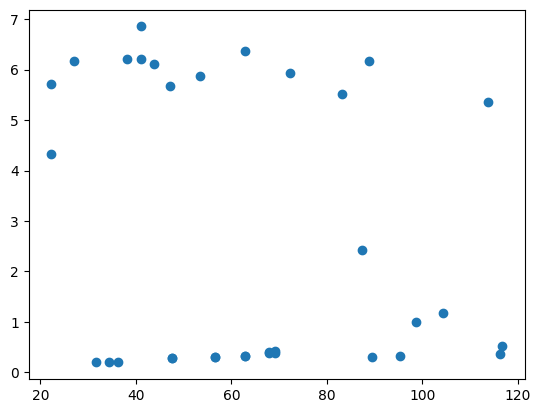

In [240]:
plt.scatter(t_fwhm,fwhm)
beta = []
for i in range(len(t_fwhm)):
    calib = cs1(t_fwhm[i])
    beta.append(fwhm[i] - calib)

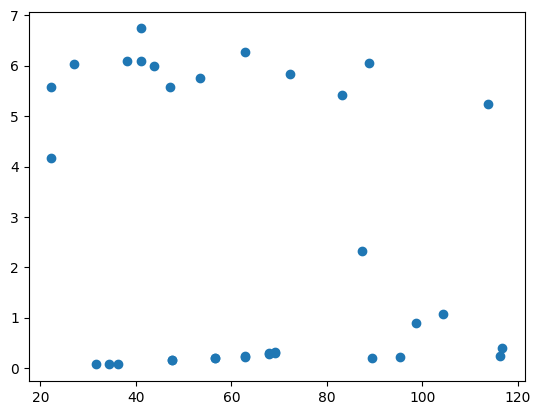

In [241]:
plt.scatter(t_fwhm,beta)

[0.16563 0.16648 0.16712 0.17212 0.17759 0.18228 0.18529 0.18672 0.1878
 0.19131 0.19624 0.20181 0.21412 0.21968 0.22443 0.23124 0.24117 0.24417
 0.26173 0.28186]
[ 31.769   34.422   36.2541  47.5401  56.5964  62.8581  66.3773  67.9491
  69.0879  72.5672  76.9613  81.3867  89.6144  92.7945  95.3092  98.6199
 102.9357 104.1356 110.3894 116.2786]
[6.85372244 6.201002   0.19737537 4.3175404  5.71829472 6.11046781
 0.20789097 0.2085562  6.16784059 0.27638064 0.2762683  6.20790215
 0.30019233 0.3014321  5.68017695 5.92774417 0.32489468 0.33124543
 5.8657479  0.37633502 0.40535573 0.38862145 0.41924435 6.37482641
 0.29715702 2.41626253 5.51864628 0.3218924  1.00407307 6.16342958
 5.35335296 1.1801224  0.35637421 0.51800907]
[ 41.04594879  41.11279387  31.7226717   22.24916016  22.31600554
  43.85344198  34.37809036  36.20719846  26.99516065  47.50532109
  47.5074058   38.09144315  56.57496019  56.57717892  47.21579662
  72.32944404  62.84078061  62.84334337  53.43238809  67.93808662
  67.936

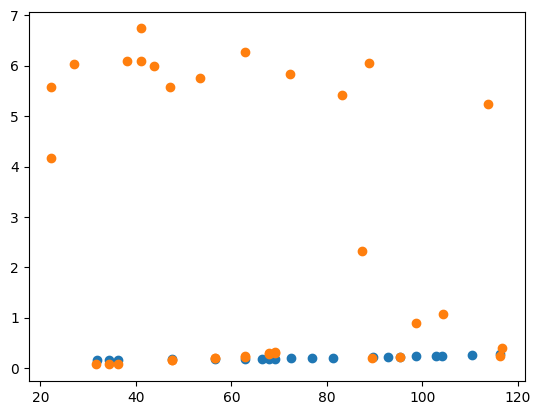

In [242]:
plt.scatter(f.two_theta,f.fwhm)
beta_f = []
for i in range(len(f.two_theta)):
    calib = cs1(f.two_theta[i])
    beta_f.append(f.fwhm[i] - calib)
# plt.scatter(f.two_theta,beta_f)
print(f.fwhm)
print(f.two_theta)
# plt.scatter(t_fwhm,fwhm)
beta_f = []
for i in range(len(t_fwhm)):
    calib = cs1(t_fwhm[i])
    beta_f.append(fwhm[i] - calib)
plt.scatter(t_fwhm,beta_f)
print(fwhm)
print(t_fwhm)


In [243]:
f.read_data_of_hkl()
print(len(f.two_theta))
print(len(f.fwhm))
# f_fwhm = del_duplicates(f.fwhm,0.001)
# print(len(f_fwhm))


20
20


In [244]:
def plot_gauss(peaks,count,x,two_theta,correct_peaks,segment_width = 15):
    color_corr = "red"
    if len(correct_peaks) == len(peaks):
        correct_peaks = peaks
        color_corr = 'k'
    x_min = np.min(x)
    x_max = np.max(x)
    # szerokość segmentu (np. 20° 2θ)
    num_segments = int(np.ceil((x_max - x_min) / segment_width))
    print(f"\nTworzę {num_segments} wykresów (co {segment_width}° 2θ)...")
    for seg in range(num_segments):
        seg_start = x_min + seg * segment_width
        seg_end = seg_start + segment_width
        mask = (x >= seg_start) & (x < seg_end)
        if not np.any(mask):
            continue
        x_seg = x[mask]
        y_seg = count[mask]
        plt.figure(figsize=(8, 5))
        plt.plot(x_seg, y_seg, label='Dane (po baseline)', alpha=0.6)
        local_peaks = [pk for pk in peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_peaks], count[local_peaks], color='k', zorder=10, label='Piki')
        local_corr_peaks = [pk for pk in correct_peaks if seg_start <= x[pk] < seg_end]
        plt.scatter(x[local_corr_peaks], count[local_corr_peaks], color=color_corr, zorder=10, label='Piki poprawne')
        for i in range(len(two_theta)):
            plt.axvline(two_theta[i], color='red', linestyle='--', linewidth=0.5)
        plt.xlim(seg_start, seg_end)
        plt.ylim(y_seg.min() * 0.9, y_seg.max() * 1.1)
        plt.title(f'Dopasowanie Gaussów: {seg_start:.1f}–{seg_end:.1f}° 2θ')
        plt.xlabel('2θ [°]')
        plt.ylabel('Intensywność')
        plt.legend(fontsize=8)
        plt.tight_layout()
        plt.show()

In [245]:
def pseudo_voigt(x, A, x0, fwhm, eta):
    """
    Pseudo-Voigt profile
    eta ∈ [0,1]  (0 = Gauss, 1 = Lorentz)
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gauss = np.exp(-(x - x0)**2 / (2 * sigma**2))
    lorentz = 1 / (1 + ((x - x0) / (fwhm / 2))**2)
    return A * (eta * lorentz + (1 - eta) * gauss)

def rr2_pv(x, y, A, x0, fwhm, eta):
    y_fit = pseudo_voigt(x, A, x0, fwhm, eta)
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot


def correction_of_peaks(peaks,two_theta,theta_start,step,eps):
    correct_index_of_counts,index_corrected = [],[]
    for i in range(len(two_theta)):
        for j in range(len(peaks)):
            if abs(peaks[j] - ((two_theta[i] - theta_start) / step)) < eps:
                correct_index_of_counts.append(peaks[j])
                index_corrected.append(j)
    return correct_index_of_counts,index_corrected

def peak_detect_pv(counts, x, heigh, dist, prom, two_theta,theta_start, step,*,r2_min = 0.6, eps = 4, plotting=False,fitting = False,correction = True, fit_range = 10):
    ''' If fitting = False - function return values:
    len(peaks),len(correct_peaks)/len(two_theta),heigh,dist,prom ;
    If fitting = True - function return values:
    peaks,correct_peaks,index_corrected,gauss_fit,_  '''
    good_index,good_peaks_intensity = [],[]
    peaks, props = find_peaks(counts, height=heigh,width=1.5,prominence=prom,distance=dist)
    if len(peaks) == 0:
        print(" Nie znaleziono pików - spróbuj obniżyć progu 'height' lub 'prominence'.")
        return False
    fitted_params,r2_list,gauss_fit  = [],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
    for pk in peaks:
        # ogranicz dane do małego okna wokół piku
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        

        # window = 8
        # left_l = max(0,pk-window)
        # right_l = max(len(counts),pk+window)
        # local_max = np.max(counts[left_l:right_l])
        # if counts[pk] < 0.8*local_max:
        #     continue 
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A_guess = counts[pk]
        x0_guess = x[pk]
        sigma_guess = 1.0
        # --- delikatna selekcja topologiczna ---
        # base_window = 6   # bardzo małe okno
        # l = max(0, pk - base_window)
        # r = min(len(counts), pk + base_window)

        # left_min  = np.min(counts[l:pk]) if pk > l else counts[pk]
        # right_min = np.min(counts[pk:r]) if pk < r else counts[pk]

        # # różnica wysokości względem lokalnych minimów
        # contrast_left  = counts[pk] - left_min
        # contrast_right = counts[pk] - right_min

        # # JEŚLI z jednej strony pik nie ma kontrastu → to ramię
        # if (contrast_left < 0.15 * counts[pk]) or (contrast_right < 0.15 * counts[pk]):
        #     continue

        try:
            popt, _ = curve_fit(
                pseudo_voigt, x_fit, y_fit,
                p0=[A_guess, x0_guess, 1.0, 0.5],   # fwhm, eta
                bounds=([0.0, x0_guess - 5.0, 0.01, 0.0],
                [np.max(counts) * 5, x0_guess + 5.0, 10.0, 1.0])
            )
            fitted_params.append(popt)
            A_fit, x0_fit, fwhm_fit, eta_fit = popt
            # oblicz R² lokalnie

            r2 = rr2_pv(x_fit, y_fit, A_fit, x0_fit, fwhm_fit, eta_fit)


            if r2 >= r2_min:
                gauss_fit.append([A_fit, x0_fit, fwhm_fit, eta_fit])
                r2_list.append(r2)
                good_index.append(pk)
            else:
                continue

        except RuntimeError:
            fitted_params.append((np.nan, np.nan, np.nan))
            r2_list.append(np.nan)
    good_peaks_intensity = (counts[good_index])
    correct_peaks,index_corrected = [],[]

    # left_b = props["left_bases"]
    # right_b = props["right_bases"]
    # proms = props["prominences"]

    # good_mask = np.isin(peaks, good_index)

    # peaks_g = peaks[good_mask]
    # left_g  = left_b[good_mask]
    # right_g = right_b[good_mask]
    # proms_g = proms[good_mask]

    # # sortujemy wg prominencji (od największych)
    # order = np.argsort(proms_g)[::-1]

    # selected = []
    # covered = []

    # margin = 2  # bardzo mały margines – DELIKATNY
    # max_prom = proms_g[order[0]] 
    # for idx in order:
    #     pk = peaks_g[idx]

    #     if proms_g[idx] < 0.15 * max_prom:
    #         continue

    #     lb = left_g[idx] + margin
    #     rb = right_g[idx] - margin

    #     # sprawdź czy pik leży w bazie już wybranego większego
    #     inside = False
    #     # for (L, R) in covered:
    #     #     if L <= pk <= R:
    #     #         inside = True
    #     #         break
    #     for (L, R) in covered:
    #         if (left_g[idx] >= L) and (right_g[idx] <= R):
    #             inside = True
    #             break

    #     if not inside:
    #         selected.append(pk)
    #         covered.append((lb, rb))

    # # FINALNE piki
    # good_index = np.array(sorted(selected))


    if correction ==  True:
        correct_peaks,index_corrected = correction_of_peaks(good_index,two_theta,theta_start,step,eps)
    # else:
    #     correct_peaks = good_peaks_intensity
    #     index_corrected = good_index
    else:
        correct_peaks = good_index           
        index_corrected = np.arange(len(good_index))   
    if plotting == True:
        plot_gauss(good_index, counts, x, two_theta,correct_peaks,30)  
    if fitting == True:
        return good_index,correct_peaks,index_corrected,np.asarray(gauss_fit),props
    return len(good_index),len(correct_peaks)/len(two_theta),heigh,dist,prom

def finding_fwhm_pv(gauss_fit, peaks_intensity):
    """
    Parameters
    ----------
    gauss_fit : (N, 3)
        [A, mu, sigma] from Gaussian fit
    peaks_intensity : (N,)
        Peak intensities (np. A or counts at peak)

    Returns
    -------
    fwhm : (N,)        [deg 2θ]
    t_fwhm : (N,)      [deg 2θ]
    weights : (N,)     normalized weights
    """
    gauss_fit = np.asarray(gauss_fit)
    peaks_intensity = np.asarray(peaks_intensity)

    sigma = np.abs(gauss_fit[:, 2])
    t_fwhm = gauss_fit[:, 1]

    fwhm = np.abs(gauss_fit[:, 2]) 

    # --- wagi ---
    w = peaks_intensity / np.nanmax(peaks_intensity)

    return fwhm, t_fwhm, w




In [246]:
@njit
def delete_aparature(counts,counts_bac,x,ap_counts,ap_x,ap_step):
    """ function to subtract aparature """
    eps = 0.5*ap_step
    end_counts = np.zeros(len(counts))
    for i in range(len(counts_bac)):
        for j in range(len(counts)):
            if abs(ap_x[i] - x[j])<eps:
                a = int(counts[j]-counts_bac[i])
                if a < 0 :
                    a = 0
                end_counts[j] = a
    return end_counts

In [287]:
@nb.njit
def delete_bac(counts, counts_bac):
    """ function to subtract background """
    return np.abs(counts - counts_bac)

[1. 6. 2. ... 2. 6. 0.]

Tworzę 4 wykresów (co 30° 2θ)...


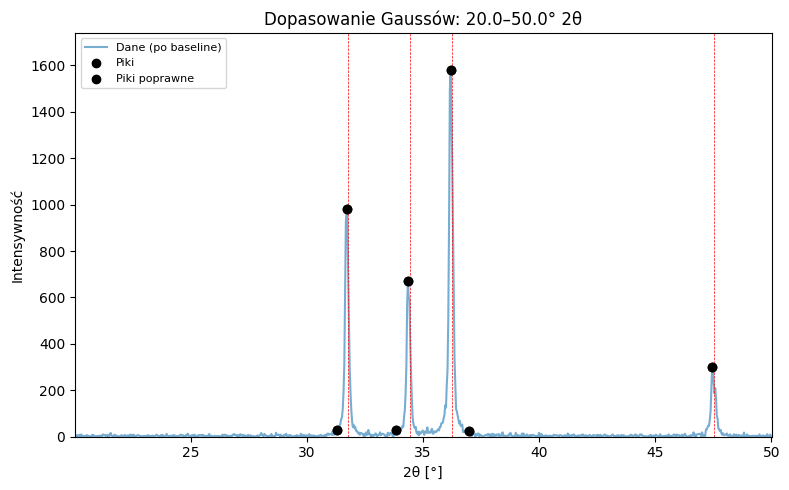

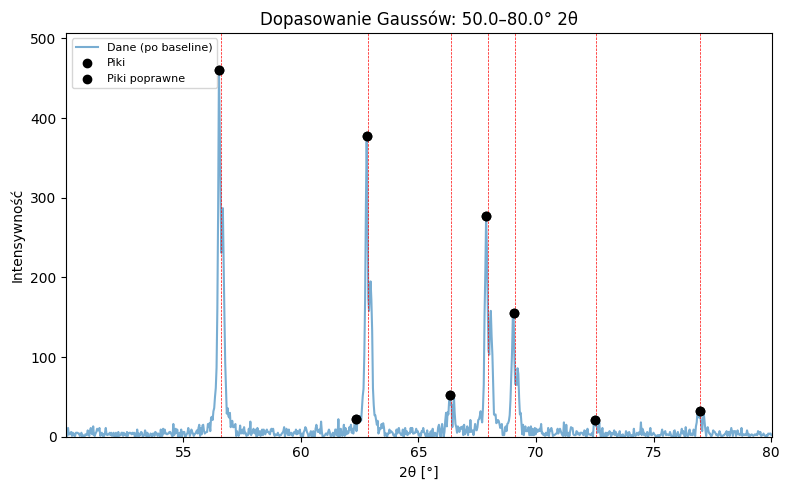

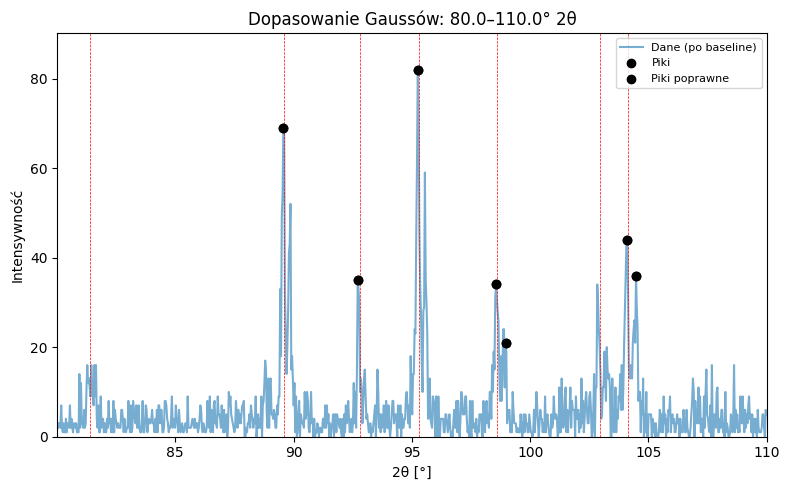

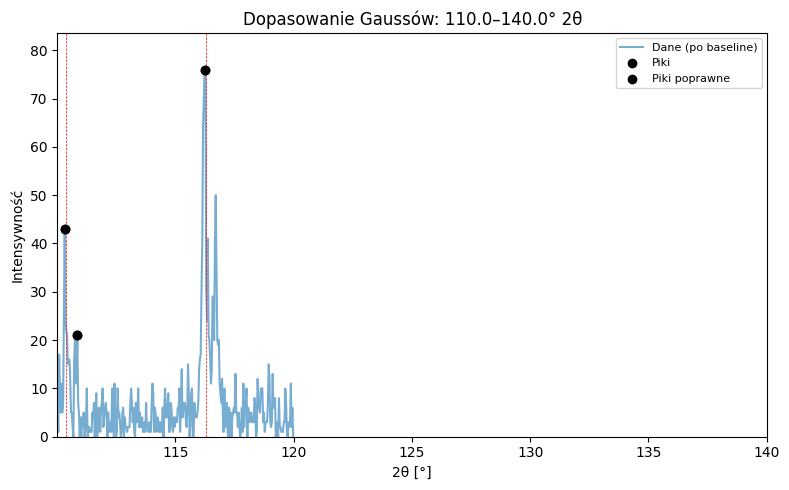

In [288]:
f.del_bac_counts(delete_bac(f.counts,f.counts_bac))
print(f.without_bac_counts)
peaks,correct_peaks,index_corrected,gauss_fit,props= peak_detect_pv(f.without_bac_counts,f.x,20, 10, 2,f.two_theta,f.theta_start,f.step,r2_min = 0.4,eps = 4,plotting=True,fitting = True,correction=False,fit_range=15)
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=False,fitting = True,correction=True)
# peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=True,fitting = True,correction=False)
fwhm,t_fwhm,peaks_weight = finding_fwhm_pv(gauss_fit,f.counts[peaks])
# which_was_found(correct_peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)
# print(props)


Tworzę 4 wykresów (co 30° 2θ)...


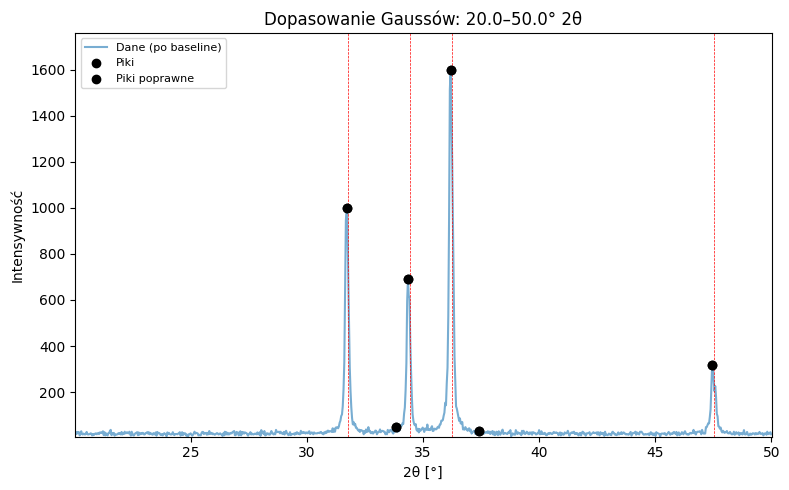

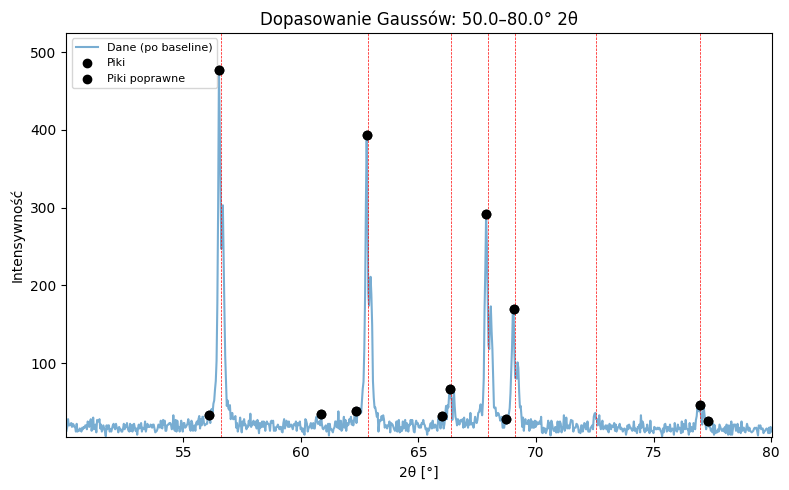

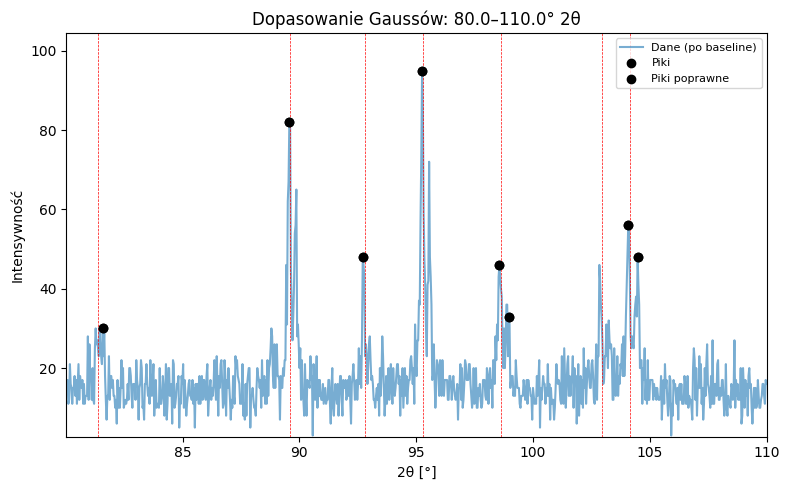

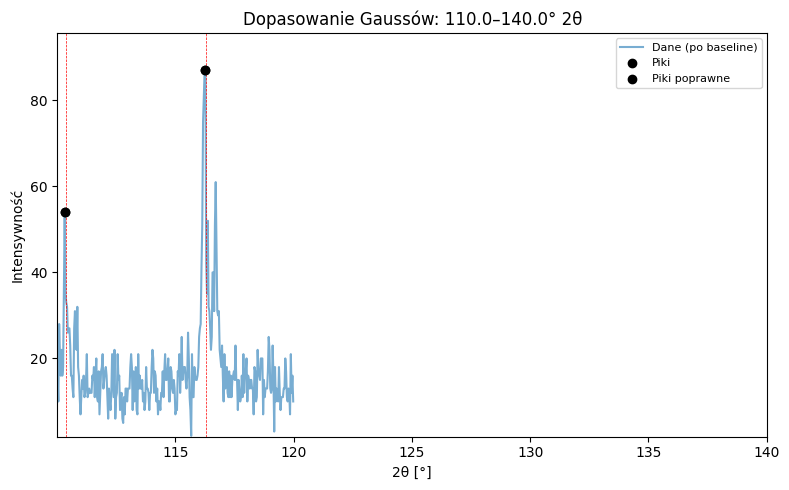

In [254]:
good_index, correct_peaks, index_corrected, pv_fit, props = peak_detect_pv(f.counts,f.x,20, 10, 2,f.two_theta,f.theta_start,f.step,r2_min = 0.3,eps = 4,plotting=True,fitting = True,correction=False,fit_range=15)


-8.049779582717488e-05
0.002877193657511629
535.4516182732038
0.0006465230706947794
0.0010020540326603855
1537.4400479281708
[np.float64(0.0005832823909758966), np.float64(0.0008413096481993044), np.float64(-0.0003767392544893746), np.float64(0.0010343730591018975), np.float64(0.0011398719667613459), np.float64(0.008196236920033032), np.float64(0.001876924284110762), np.float64(0.0026294978734107367), np.float64(0.0005293688344673872), np.float64(0.0017466182729889358), np.float64(0.0040603798303390694), np.float64(0.0021301978976904726), np.float64(0.0018973654523233338), np.float64(0.002346819322675427), np.float64(0.00336810034628494)]


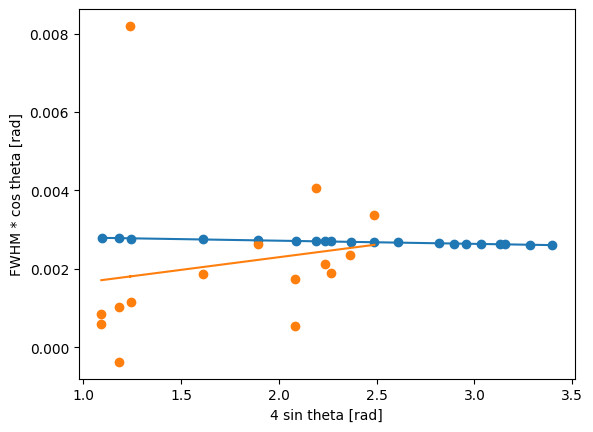

In [289]:
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(f.two_theta)):
    xlinewh.append(4*(math.sin(f.two_theta[i]/2*PI/180)))
    ylinewh.append((f.fwhm[i]*PI/180)*(math.cos(f.two_theta[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
# plt.show()
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(t_fwhm)-10):
    xlinewh.append(4*(math.sin(t_fwhm[i]/2*PI/180)))
    ylinewh.append(((fwhm[i] - cs1(t_fwhm[i])))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
    # ylinewh.append((math.sqrt(fwhm[i]**2 - cs1(t_fwhm[i])**2))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
plt.xlabel("4 sin theta [rad]")
plt.ylabel("FWHM * cos theta [rad]")
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)
print(ylinewh)

In [279]:
import numpy as np
import matplotlib.pyplot as plt

def plot_found_peaks_with_fwhm_and_fit(
    x,
    counts,
    peaks_idx,
    fit_params,
    *,
    model="pvoigt",       # "gauss" lub "pvoigt"
    n_panels=4,
    fit_window=3.0,       # ile × FWHM brać do pokazania krzywej
    title="XRD: znalezione piki + FWHM + dopasowanie"
):
    """
    Rysuje wykres jak na Twoim screenie, ale tylko dla znalezionych pików.

    Parametry
    ---------
    x, counts : 1D
    peaks_idx : 1D int
        indeksy pików (w tablicy counts/x)
    fit_params : array-like
        Gauss:  [A, x0, sigma]
        pVoigt: [A, x0, fwhm, eta]
        Kolejność MUSI odpowiadać peaks_idx (po tym samym filtrowaniu).
    model : "gauss" / "pvoigt"
    """

    x = np.asarray(x)
    counts = np.asarray(counts)
    peaks_idx = np.asarray(peaks_idx, dtype=int)
    fit_params = np.asarray(fit_params, dtype=float)

    if len(peaks_idx) == 0:
        print("Brak pików do narysowania.")
        return

    if len(peaks_idx) != len(fit_params):
        raise ValueError("peaks_idx i fit_params muszą mieć tę samą długość (po filtrowaniu).")

    # oblicz FWHM i pozycje piku z parametrów dopasowania
    if model == "gauss":
        A = fit_params[:, 0]
        x0 = fit_params[:, 1]
        sigma = np.abs(fit_params[:, 2])
        fwhm = 2 * sigma * np.sqrt(2 * np.log(2))
    elif model == "pvoigt":
        A = fit_params[:, 0]
        x0 = fit_params[:, 1]
        fwhm = np.abs(fit_params[:, 2])
        eta = fit_params[:, 3]
    else:
        raise ValueError("model musi być 'gauss' albo 'pvoigt'.")

    # podział na panele
    x_min = x.min()
    x_max = x.max()
    panel_width = (x_max - x_min) / n_panels

    fig, axes = plt.subplots(n_panels, 1, figsize=(12, 3.0 * n_panels), sharex=False)
    if n_panels == 1:
        axes = [axes]

    for p, ax in enumerate(axes):
        left = x_min + p * panel_width
        right = left + panel_width

        mask = (x >= left) & (x < right)
        if not np.any(mask):
            ax.set_visible(False)
            continue

        x_seg = x[mask]
        y_seg = counts[mask]
        ax.plot(x_seg, y_seg, color="black", lw=1)

        # autoskala Y
        ymin, ymax = y_seg.min(), y_seg.max()
        dy = ymax - ymin if ymax > ymin else 1.0
        ax.set_ylim(ymin - 0.05 * dy, ymax + 0.20 * dy)

        # piki, które wpadają do tego panelu
        for pk_i, pk in enumerate(peaks_idx):
            xpk = x[pk]
            if not (left <= xpk < right):
                continue

            # pionowa kreska w miejscu piku
            ax.axvline(xpk, color="red", linestyle="--", alpha=0.6)

            # FWHM jako pozioma niebieska linia
            half = fwhm[pk_i] / 2.0
            y_peak = counts[pk]
            ax.hlines(y_peak / 2.0, xpk - half, xpk + half, color="blue", linewidth=2)

            # narysuj krzywą dopasowania na oknie ~fit_window*FWHM
            w = fit_window * fwhm[pk_i]
            x_fit = x[(x >= xpk - w) & (x <= xpk + w)]
            if len(x_fit) < 5:
                continue

            if model == "gauss":
                y_fit = gaussian(x_fit, fit_params[pk_i][0], fit_params[pk_i][1], fit_params[pk_i][2])
                ax.plot(x_fit, y_fit, color="green", lw=2)
            else:  # pvoigt
                y_fit = pseudo_voigt(x_fit, fit_params[pk_i][0], fit_params[pk_i][1], fit_params[pk_i][2], fit_params[pk_i][3])
                ax.plot(x_fit, y_fit, color="darkorange", lw=2)

        ax.set_xlim(left, right)
        ax.set_ylabel("Counts")
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel(r"$2\theta$ [°]")
    fig.suptitle(f"{title} ({model})", fontsize=14)
    plt.tight_layout()
    plt.show()


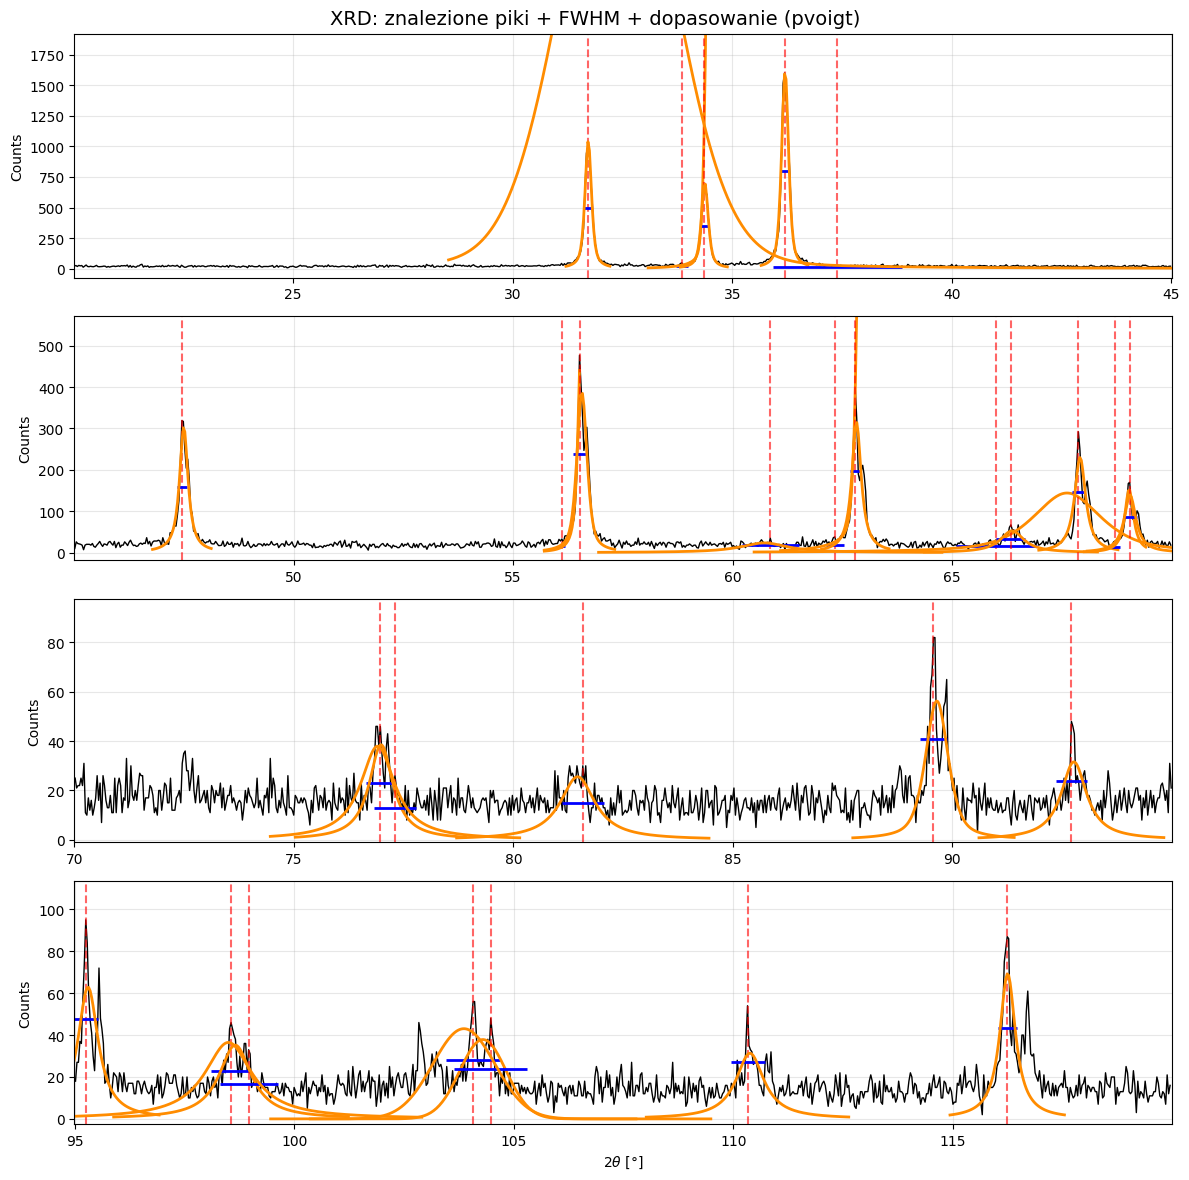

In [280]:
plot_found_peaks_with_fwhm_and_fit(
    x=f.x,
    counts=f.counts,
    peaks_idx=good_index,
    fit_params=pv_fit,
    model="pvoigt",
    n_panels=4,
    fit_window=3.0,
    title="XRD: znalezione piki + FWHM + dopasowanie"
)

In [281]:


def correction_of_peaks(peaks,two_theta,theta_start,step,eps):
    correct_index_of_counts,index_corrected = [],[]
    for i in range(len(two_theta)):
        for j in range(len(peaks)):
            if abs(peaks[j] - ((two_theta[i] - theta_start) / step)) < eps:
                correct_index_of_counts.append(peaks[j])
                index_corrected.append(j)
    return correct_index_of_counts,index_corrected

def peak_detect(counts, x, heigh, dist, prom, two_theta,theta_start, step,*,r2_min = 0.6, eps = 4, plotting=False,fitting = False,correction = True, fit_range = 10):
    ''' If fitting = False - function return values:
    len(peaks),len(correct_peaks)/len(two_theta),heigh,dist,prom ;
    If fitting = True - function return values:
    peaks,correct_peaks,index_corrected,gauss_fit,_  '''
    good_index,good_peaks_intensity = [],[]
    peaks, props = find_peaks(counts, height=heigh,width=1.5,prominence=prom,distance=dist)
    if len(peaks) == 0:
        print(" Nie znaleziono pików - spróbuj obniżyć progu 'height' lub 'prominence'.")
        return False
    fitted_params,r2_list,gauss_fit  = [],[],[]  # (A, x0, sigma) dla każdego dopasowanego piku
    for pk in peaks:
        # ogranicz dane do małego okna wokół piku
        left = max(0, pk - fit_range)
        right = min(len(x), pk + fit_range)
        

        # window = 8
        # left_l = max(0,pk-window)
        # right_l = max(len(counts),pk+window)
        # local_max = np.max(counts[left_l:right_l])
        # if counts[pk] < 0.8*local_max:
        #     continue 
        x_fit = x[left:right]
        y_fit = counts[left:right]
        A_guess = counts[pk]
        x0_guess = x[pk]
        sigma_guess = 1.0
        # --- delikatna selekcja topologiczna ---
        base_window = 6   # bardzo małe okno
        l = max(0, pk - base_window)
        r = min(len(counts), pk + base_window)

        left_min  = np.min(counts[l:pk]) if pk > l else counts[pk]
        right_min = np.min(counts[pk:r]) if pk < r else counts[pk]

        # różnica wysokości względem lokalnych minimów
        contrast_left  = counts[pk] - left_min
        contrast_right = counts[pk] - right_min

        # JEŚLI z jednej strony pik nie ma kontrastu → to ramię
        if (contrast_left < 0.15 * counts[pk]) or (contrast_right < 0.15 * counts[pk]):
            continue

        try:
            popt, _ = curve_fit(
                gaussian, x_fit, y_fit,
                p0=[A_guess, x0_guess, sigma_guess],
                bounds=([0.0, x0_guess - 5.0, 0.01],
                        [np.max(counts) * 5, x0_guess + 5.0, 10.0])
            )
            fitted_params.append(popt)
            A_fit, x0_fit, sigma_fit = popt
            # oblicz R² lokalnie

            r2 = rr2(
                np.asarray(x_fit, dtype=np.float64),
                np.asarray(y_fit, dtype=np.float64),
                np.float64(A_fit),
                np.float64(x0_fit),
                np.float64(sigma_fit)
            )


            if r2 >= r2_min:
                gauss_fit.append([A_fit, x0_fit, sigma_fit])
                r2_list.append(r2)
                good_index.append(pk)
            else:
                continue

        except RuntimeError:
            fitted_params.append((np.nan, np.nan, np.nan))
            r2_list.append(np.nan)
    good_peaks_intensity = (counts[good_index])
    correct_peaks,index_corrected = [],[]

    # left_b = props["left_bases"]
    # right_b = props["right_bases"]
    # proms = props["prominences"]

    # good_mask = np.isin(peaks, good_index)

    # peaks_g = peaks[good_mask]
    # left_g  = left_b[good_mask]
    # right_g = right_b[good_mask]
    # proms_g = proms[good_mask]

    # # sortujemy wg prominencji (od największych)
    # order = np.argsort(proms_g)[::-1]

    # selected = []
    # covered = []

    # margin = 2  # bardzo mały margines – DELIKATNY
    # max_prom = proms_g[order[0]] 
    # for idx in order:
    #     pk = peaks_g[idx]

    #     if proms_g[idx] < 0.15 * max_prom:
    #         continue

    #     lb = left_g[idx] + margin
    #     rb = right_g[idx] - margin

    #     # sprawdź czy pik leży w bazie już wybranego większego
    #     inside = False
    #     # for (L, R) in covered:
    #     #     if L <= pk <= R:
    #     #         inside = True
    #     #         break
    #     for (L, R) in covered:
    #         if (left_g[idx] >= L) and (right_g[idx] <= R):
    #             inside = True
    #             break

    #     if not inside:
    #         selected.append(pk)
    #         covered.append((lb, rb))

    # # FINALNE piki
    # good_index = np.array(sorted(selected))


    if correction ==  True:
        correct_peaks,index_corrected = correction_of_peaks(good_index,two_theta,theta_start,step,eps)
    # else:
    #     correct_peaks = good_peaks_intensity
    #     index_corrected = good_index
    else:
        correct_peaks = good_index           
        index_corrected = np.arange(len(good_index))   
    if plotting == True:
        plot_gauss(good_index, counts, x, two_theta,correct_peaks,30)  
    if fitting == True:
        return good_index,correct_peaks,index_corrected,np.asarray(gauss_fit),props
    return len(good_index),len(correct_peaks)/len(two_theta),heigh,dist,prom

def finding_fwhm(gauss_fit, peaks_intensity):
    """
    Parameters
    ----------
    gauss_fit : (N, 3)
        [A, mu, sigma] from Gaussian fit
    peaks_intensity : (N,)
        Peak intensities (np. A or counts at peak)

    Returns
    -------
    fwhm : (N,)        [deg 2θ]
    t_fwhm : (N,)      [deg 2θ]
    weights : (N,)     normalized weights
    """
    gauss_fit = np.asarray(gauss_fit)
    peaks_intensity = np.asarray(peaks_intensity)

    sigma = np.abs(gauss_fit[:, 2])
    t_fwhm = gauss_fit[:, 1]

    fwhm = 2 * sigma * np.sqrt(2 * np.log(2))

    # --- wagi ---
    w = peaks_intensity / np.nanmax(peaks_intensity)

    return fwhm, t_fwhm, w




In [282]:
# peaks,correct_peaks,index_corrected,gauss_fit,props= peak_detect(f.counts,f.x,35, 50, 2,f.two_theta,f.theta_start,f.step,r2_min = 0.4,eps = 4,plotting=True,fitting = True,correction=True)
# # peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=False,fitting = True,correction=True)
# # peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=True,fitting = True,correction=False)
# fwhm,t_fwhm,peaks_weight = finding_fwhm(gauss_fit,f.counts[peaks])
# which_was_found(correct_peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)
# print(props)


Tworzę 4 wykresów (co 30° 2θ)...


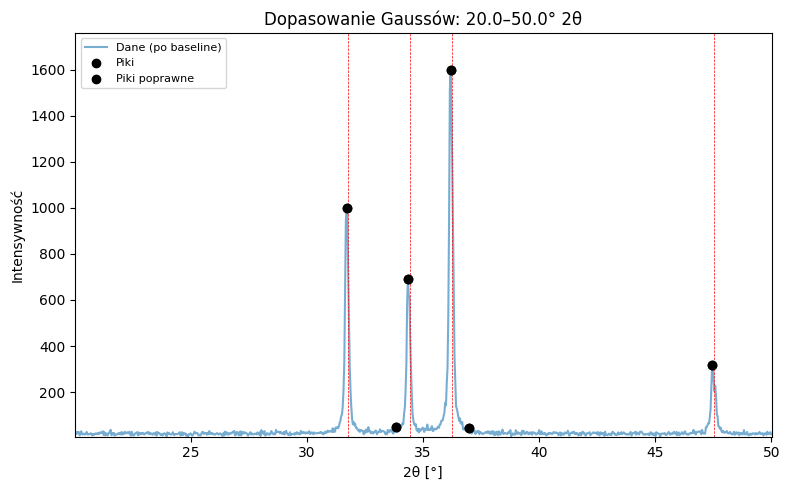

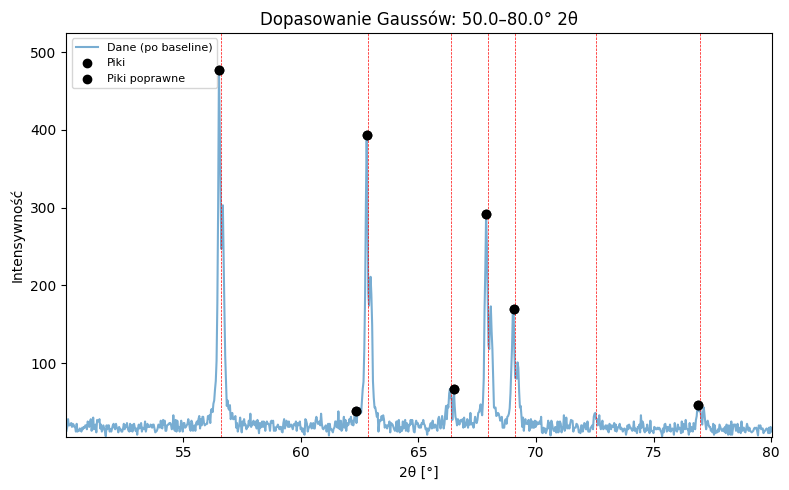

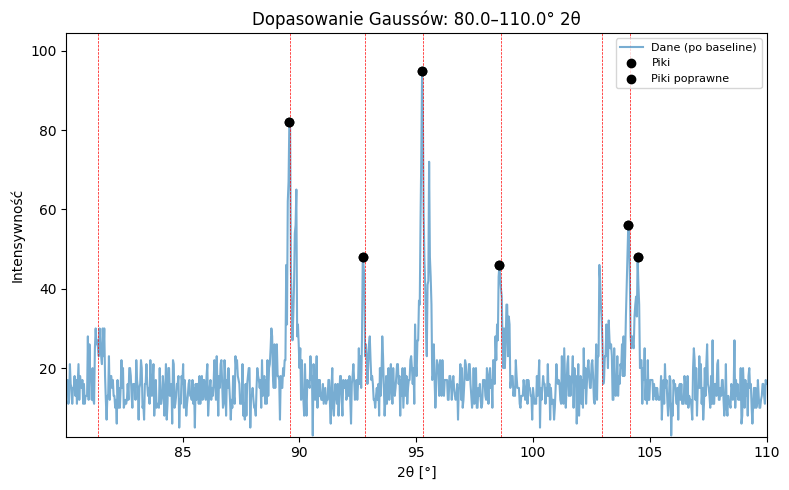

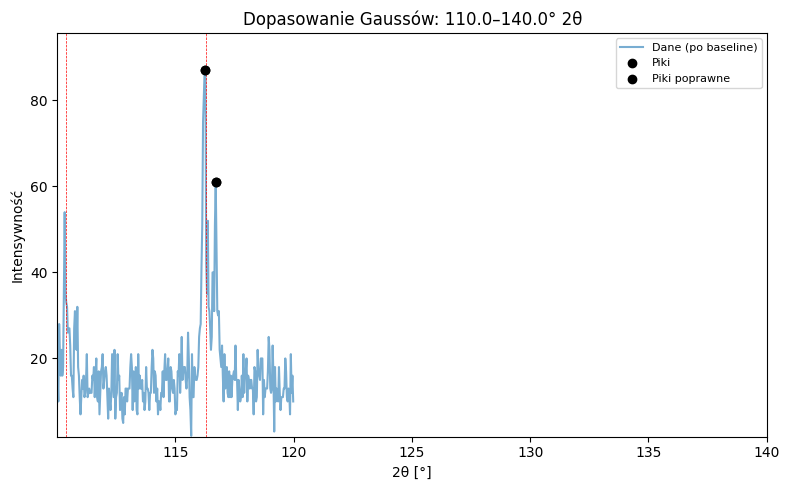

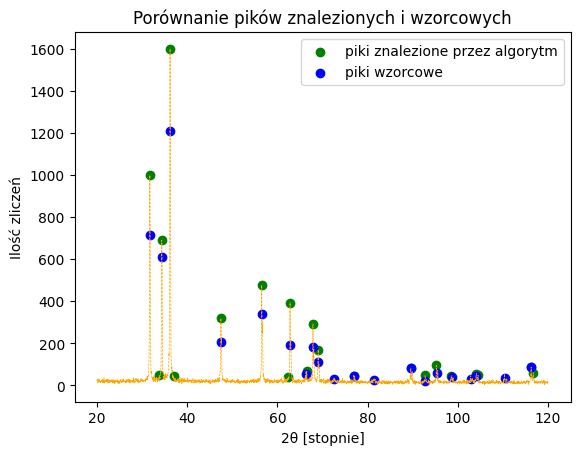

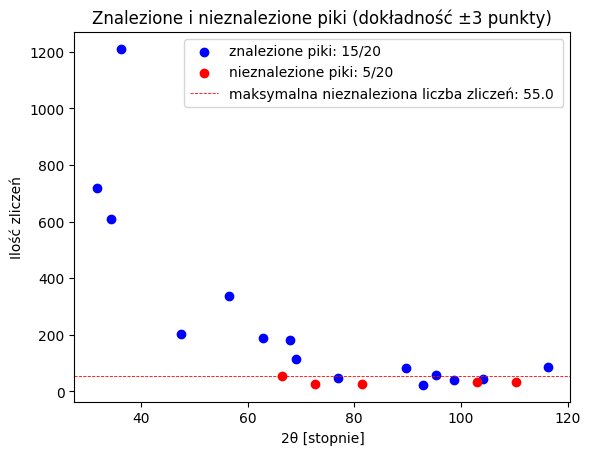

{'peak_heights': array([  36.,   35.,   36.,   47.,  999.,   48.,   38.,   48.,  690.,
       1600.,   43.,   37.,   35.,   35.,  319.,  477.,   35.,   35.,
         38.,  393.,   67.,  292.,  170.,   36.,   46.,   82.,   48.,
         95.,   46.,   46.,   56.,   48.,   54.,   87.,   61.]), 'prominences': array([  24.,   23.,   23.,    4.,  982.,   31.,   21.,   20.,  665.,
       1593.,   11.,   24.,   27.,   27.,  312.,  471.,   24.,   27.,
         15.,  386.,   50.,  284.,  153.,   29.,   40.,   77.,   40.,
         92.,   39.,   34.,   51.,   23.,   51.,   84.,   39.]), 'left_bases': array([  42,  145,  145,  145,  145,  372,  389,  402,  402,  145,  506,
        545,  562,  562,  754,  948, 1121, 1201, 1232, 1232, 1357, 1357,
       1455, 1514, 1656, 2031, 2111, 2111, 2297, 2402, 2402, 2522, 2570,
       2862, 2887]), 'right_bases': array([ 145,  245,  275,  339,  372,  389,  400,  416,  443, 2862,  754,
        754,  754,  754,  948, 2862, 1232, 1232, 1267, 2862, 1403, 2862,
   

In [ ]:
# peaks,correct_peaks,index_corrected,gauss_fit,props= peak_detect(f.counts,f.x,35, 10, 2,f.two_theta,f.theta_start,f.step,r2_min = 0.3,eps = 4,plotting=True,fitting = True,correction=False,fit_range=15)
# # peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=False,fitting = True,correction=True)
# # peaks,correct_peaks,index_corrected,gauss_fit,_ = peak_detect(f.counts,f.x,20, 50, 0.001,f.two_theta,f.theta_start,f.step,eps = 4,plotting=True,fitting = True,correction=False)
# fwhm,t_fwhm,peaks_weight = finding_fwhm(gauss_fit,f.counts[peaks])
# which_was_found(correct_peaks,f.x,f.counts,f.two_theta,f.two_theta_in_counts)
# print(props)

In [284]:
# # fwhm,t_fwhm,_ = finding_fwhm(f.without_aparature_counts,index_corrected,f.x,gauss_fit,f.theta_start,f.step)
# xx,yy = [],[]
# for i in range(len(fwhm)):
#     # if abs(beta[i]/2*math.cos(t_fwhm[i]/2))<3:
#     yy.append(beta[i]/2*math.cos(t_fwhm[i]/2))
#     xx.append(math.sin(t_fwhm[i]/2))

# a, b = np.polyfit(xx, yy, 1)

# print("a =", a)
# print("b =", b)
# y = []
# for i in range(len(xx)):
#     y.append(a*xx[i]+b)
# plt.plot(xx,y,color = "blue")
# plt.scatter(xx,yy,color = "blue")
# xx,yy = [],[]
# for i in range(len(f.fwhm)):
#     xx.append(math.sin(f.two_theta[i]/2))
#     yy.append(f.fwhm[i]/2*math.cos(f.two_theta[i]/2))
# a_ref, b_ref = np.polyfit(xx, yy, 1)

# print("a =", a_ref)
# print("b =", b_ref)
# y = []
# for i in range(len(xx)):
#     y.append(a_ref*xx[i]+b_ref)
# plt.plot(xx,y,color = "green")
# plt.scatter(xx,yy,color = "green")
# plt.xlabel("sin(theta)")
# plt.ylabel("fwhm*cos(theta)")
# # plt.ylim(-2,2)
# plt.show()
# xx,yy = [],[]
# # for i in range(len(diff)):
# #     xx.append(math.sin(t_fwhm[i]))
# #     yy.append(diff[i]*math.cos(t_fwhm[i]))
# # plt.scatter(xx,yy,color = "red")
# # plt.xlabel("sin(theta)")
# # plt.ylabel("fwhm*cos(theta)")
# # plt.show()

In [285]:
K = 0.94
PI = 3.141592654
lambda_ = f.kalpha1
# size1 = (K*lambda_)/b
# size_ref = (K*lambda_)/b_ref
X_strain = f.xy_and_u_fitted[0]
Y_size = f.xy_and_u_fitted[2]
size_ref_files = (K*lambda_*180)/(PI*Y_size)
# print(size1)
# print(size_ref)
print(size_ref_files)
print(f.xy_and_u_fitted)
print(lambda_)
print(f.uvw_xy)
# for i in range(len(f.two_theta)):
# strain1 = a/4
# strain_ref = a_ref/4
strain_ref_files = PI*X_strain/1.8
# print(strain1)
# print(strain_ref)
print(strain_ref_files)

976.1597354809854
[9e-05, 2.7581000000000006e-05, 0.085, 0.013542271000000002]
1.540598
False
0.00015707963270000002


In [ ]:
dd = []
for i in range(len(f.fwhm)):
    dd.append(K*lambda_/((f.fwhm[i]*PI/180)*math.cos(f.two_theta[i]/2*PI/180)))
    # dd.append(K*lambda_/(((f.fwhm[i]-cs1(f.two_theta[i]))*PI/180)*math.cos(f.two_theta[i]/2*PI/180)))

d =np.mean(np.asarray(dd))
print(d)


1218.9674056505278


In [295]:
dd = []
for i in range(len(fwhm)):
    dd.append(K*lambda_/(((fwhm[i] - cs1(t_fwhm[i]))*PI/180)*math.cos(t_fwhm[i]/2*PI/180)))
d =np.mean(np.asarray(dd))
print(d)


720.0157678620405


In [263]:
# plt.scatter(f.two_theta,f.fwhm)
# beta_f = []
# for i in range(len(f.two_theta)):
#     calib = cs1(f.two_theta[i])
#     beta_f.append(f.fwhm[i] - calib)
# plt.scatter(f.two_theta,beta_f)

# xx_3,yy_3 = [],[]
# for i in range(len(f.fwhm)):
#     xx_3.append(math.sin((f.two_theta[i]/2)*PI/180))
#     yy_3.append((f.fwhm[i]*PI/180)*math.cos((f.two_theta[i]/2)*PI/180))
# a_3, b_3 = np.polyfit(xx_3, yy_3, 1)

# print("a =", a_3)
# print("b =", b_3)
# y_ = []
# for i in range(len(xx_3)):
#     y_.append(a_3*xx_3[i]+b_3)
# plt.plot(xx_3,y_,color = "blue")
# plt.scatter(xx_3,yy_3,color = "blue")
# xx_,yy_ = [],[]

# for i in range(len(f.fwhm)):
#     xx_.append(math.sin(f.two_theta[i]/2))
#     yy_.append(f.fwhm[i]/2*math.cos(f.two_theta[i]/2))
# a_, b_ = np.polyfit(xx_, yy_, 1)

# print("a =", a_)
# print("b =", b_)
# y_ = []
# for i in range(len(xx_)):
#     y_.append(a_*xx_[i]+b_)
# plt.plot(xx_,y_,color = "blue")
# plt.scatter(xx_,yy_,color = "blue")
# K = 0.94
# lambda_ = f.kalpha1
# size_ref = (K*lambda_)/b_
# X_strain = f.xy_and_u_fitted[0]
# Y_size = f.xy_and_u_fitted[2]
# size_ref_files = (K*lambda_*180)/(PI*Y_size)
# # size_ref_chat = f.scherrer_size()
# size_ref_chat = (K*lambda_)/b_3



# print(size_ref)
# print(size_ref_files)
# print(size_ref_chat)
# print(f.xy_and_u_fitted)
# print(lambda_)
# print(f.uvw_xy)

# # for i in range(len(f.two_theta)):
# strain_ref = a_/4
# strain_ref_files = PI*X_strain/1.8
# print(strain_ref)
# print(strain_ref_files)
    

In [264]:
# # yline = [math.log(f.fwhm[2]*PI/180),math.log(f.fwhm[4]*PI/180),math.log(f.fwhm[7]*PI/180),math.log(f.fwhm[9]*PI/180)]
# # xline = [math.log(1/(math.cos(f.two_theta[2]/2*PI/180))),math.log(1/(math.cos(f.two_theta[4]/2*PI/180))),math.log(1/(math.cos(f.two_theta[7]/2*PI/180))),math.log(1/(math.cos(f.two_theta[9]/2*PI/180)))]

# # dopasowanie scherera ale z logarytmem (S-M) podobno dobrze idk 
# xline,yline = [],[]
# for i in range(len(f.two_theta)-15):
#     xline.append(math.log(1/(math.cos(f.two_theta[i]/2*PI/180))))
#     yline.append(math.log(f.fwhm[i]*PI/180))
# plt.scatter(xline,yline)

# aschr, bschr= np.polyfit(xline, yline, 1)
# y_line = []
# for i in range(len(xline)):
#     y_line.append(aschr*xline[i]+bschr)
# plt.plot(xline,y_line)
# print(aschr)
# print(bschr)
# size_schr = 1*f.kalpha1/math.e**bschr
# print(size_schr)

[0.16563 0.16648 0.16712 0.17212 0.17759 0.18228 0.18529 0.18672 0.1878
 0.19131 0.19624 0.20181 0.21412 0.21968 0.22443 0.23124 0.24117 0.24417
 0.26173 0.28186]
[ 31.769   34.422   36.2541  47.5401  56.5964  62.8581  66.3773  67.9491
  69.0879  72.5672  76.9613  81.3867  89.6144  92.7945  95.3092  98.6199
 102.9357 104.1356 110.3894 116.2786]
-8.049779582717488e-05
0.002877193657511629
535.4516182732038
-0.0020180964793563177
0.01506446658210362
102.26701301393634


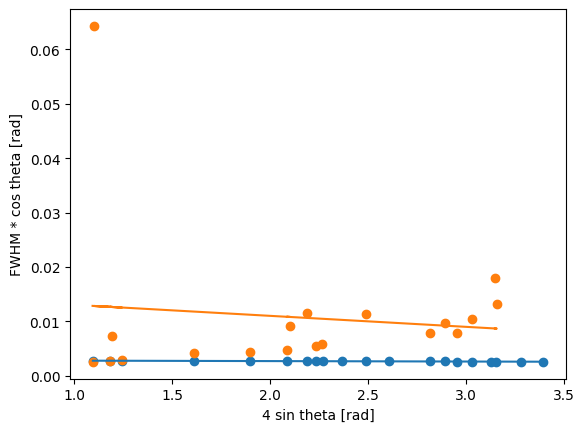

In [271]:
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(f.two_theta)):
    xlinewh.append(4*(math.sin(f.two_theta[i]/2*PI/180)))
    ylinewh.append((f.fwhm[i]*PI/180)*(math.cos(f.two_theta[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)
print(f.fwhm)
print(f.two_theta)
awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
# plt.show()
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(t_fwhm)-2):
    xlinewh.append(4*(math.sin(t_fwhm[i]/2*PI/180)))
    ylinewh.append((math.sqrt(fwhm[i]**2 - cs1(t_fwhm[i])**2))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
plt.xlabel("4 sin theta [rad]")
plt.ylabel("FWHM * cos theta [rad]")
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)

0.0005067658450594161
0.010797951405398966
142.6750262304109


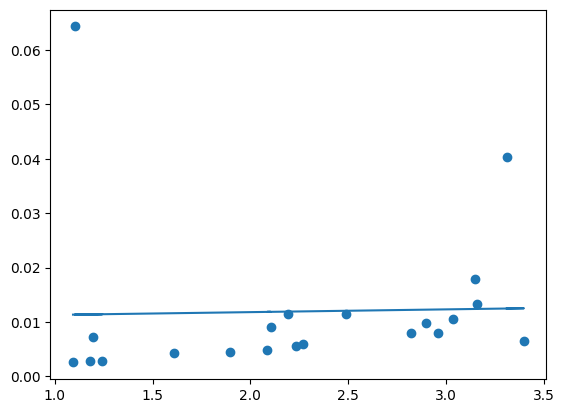

In [266]:
#załóżmy że to jest dobrze 

xlinewh,ylinewh = [],[]
for i in range(len(t_fwhm)):
    xlinewh.append(4*(math.sin(t_fwhm[i]/2*PI/180)))
    ylinewh.append((math.sqrt(fwhm[i]**2 - cs1(t_fwhm[i])**2))*PI/180*(math.cos(t_fwhm[i]/2*PI/180)))
plt.scatter(xlinewh,ylinewh)

awh, bwh= np.polyfit(xlinewh, ylinewh, 1)
y_linewh = []
for i in range(len(xlinewh)):
    y_linewh.append(awh*xlinewh[i]+bwh)
plt.plot(xlinewh,y_linewh)
print(awh)
print(bwh)
size_wh = 1*f.kalpha1/bwh
print(size_wh)